In [1]:
%reset 
# clears variables in workspace
# note on resetting:
# especially while you're debugging, you want to clear your variables between attempts to solve. Why?
# A) you may have noticed that pyomo doesn't like things being redefined
# more importantly, B) the variables keep their values, so an infeasible solution becomes an infeasible guess. 

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np
sym.init_printing()
from IPython.display import display #for pretty printing
import log

#plotting
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import PillowWriter
%matplotlib inline

# Ready for a new run, with the travel distance increased.
gait_name = "TwoD_SS_lift_61"
path = "/Users/Marethe/Documents/GitHub/Masters/2D_gait_generation/Results/"

logger = log.setup_custom_logger(log_level = "INFO", log_path="C:"+path)
logger.info("-------------------------------------------------------")
logger.info(f"Gait name: {gait_name}")
logger.info("2D SS walk - initial and final positions the same")
logger.info("contact order enforced")
logger.info("Slip and friction implemented as slack variables")
logger.info("-------------------------------------------------------")    

# create the model
m = ConcreteModel()
m.clear()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


[2023-10-27T09:12:40+0200.0913][INFO ][<ipython-input-1-eacaba75adb7>] - -------------------------------------------------------
[2023-10-27T09:12:40+0200.0913][INFO ][<ipython-input-1-eacaba75adb7>] - Gait name: TwoD_SS_lift_61
[2023-10-27T09:12:40+0200.0913][INFO ][<ipython-input-1-eacaba75adb7>] - 2D SS walk - initial and final positions the same
[2023-10-27T09:12:40+0200.0927][INFO ][<ipython-input-1-eacaba75adb7>] - contact order enforced
[2023-10-27T09:12:40+0200.0929][INFO ][<ipython-input-1-eacaba75adb7>] - Slip and friction implemented as slack variables
[2023-10-27T09:12:40+0200.0930][INFO ][<ipython-input-1-eacaba75adb7>] - -------------------------------------------------------


## Variables

In [2]:
#Node Points
N = 40
cN = 3

#Mass
FemurMass = 0.223 #kg
TibiaMass = 0.086 #kg
BodyMass = 1.885 #kg

#Lengths
FemurLength = 0.115 #m
TibiaLength = 0.112 #m
BodyLength = 0.335 #m

#Servo Motor Specs
m.Tmax = 6.864655 #Nm, corresponding to a 8V input
m.Wmax = 8.055366 #rad/s, corresponding to a 8V input

#Time Bounds
tmax = 0.3 #s 0.4 was okay
tmin = 0.01 #s
hm = 1 #factor

#Travel distance
m.distance = 0.05 #m
m.vel = 0.1 #m/s
z_clearance = 0.02 #m

pi=np.pi

logger.info(f"Nodes = {N}, time variable {tmax}-{tmin}")
logger.info(f"m.distance = {m.distance}")
logger.info(f"z_clearance = {z_clearance}")
logger.info(f"TibiaLength = {TibiaLength}")


[2023-10-27T09:12:40+0200.0951][INFO ][<ipython-input-2-26ee0cfc44dc>] - Nodes = 40, time variable 0.3-0.01
[2023-10-27T09:12:40+0200.0953][INFO ][<ipython-input-2-26ee0cfc44dc>] - m.distance = 0.05
[2023-10-27T09:12:40+0200.0955][INFO ][<ipython-input-2-26ee0cfc44dc>] - z_clearance = 0.02
[2023-10-27T09:12:40+0200.0958][INFO ][<ipython-input-2-26ee0cfc44dc>] - TibiaLength = 0.112


## Symbolic Equations

In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4 = sym.symbols(['m_{body}','m_{femur1}','m_{tibia1}','m_{femur2}','m_{tibia2}','m_{femur3}','m_{tibia3}','m_{femur4}','m_{tibia4}']) # mass of links
l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4 = sym.symbols(['l_{body}','l_{femur1}','l_{tibia1}','l_{femur2}','l_{tibia2}','l_{femur3}','l_{tibia3}','l_{femur4}','l_{tibia4}']) # length of links
In_b,In_f1,In_t1,In_f2,In_t2,In_f3,In_t3,In_f4,In_t4= sym.symbols(['In_{body}','In_{femur1}','In_{tibia1}','In_{femur2}','In_{tibia2}','In_{femur3}','In_{tibia3}','In_{femur4}','In_{tibia4}']) # moment of intertia of links

# generalized coordinates
x,z,th_b,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4 = sym.symbols(['x','z','theta_{body}','theta_{hip1}','theta_{knee1}','theta_{hip2}','theta_{knee2}','theta_{hip3}','theta_{knee3}','theta_{hip4}','theta_{knee4}']) #position
dx,dz,dth_b,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4 = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{body}','\dot{\\theta}_{hip1}','\dot{\\theta}_{knee1}','\dot{\\theta}_{hip2}','\dot{\\theta}_{knee2}','\dot{\\theta}_{hip3}','\dot{\\theta}_{knee3}','\dot{\\theta}_{hip4}','\dot{\\theta}_{knee4}']) #velocity
ddx,ddz,ddth_b,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4 = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{body}','\ddot{\\theta}_{hip1}','\ddot{\\theta}_{knee1}','\ddot{\\theta}_{hip2}','\ddot{\\theta}_{knee2}','\ddot{\\theta}_{hip3}','\ddot{\\theta}_{knee3}','\ddot{\\theta}_{hip4}','\ddot{\\theta}_{knee4}']) #acceleration

q = sym.Matrix([[x],[z],[th_b],[th_h1],[th_k1],[th_h2],[th_k2],[th_h3],[th_k3],[th_h4],[th_k4]]) #group into matrices
dq = sym.Matrix([[dx],[dz],[dth_b],[dth_h1],[dth_k1],[dth_h2],[dth_k2],[dth_h3],[dth_k3],[dth_h4],[dth_k4]])
ddq = sym.Matrix([[ddx],[ddz],[ddth_b],[ddth_h1],[ddth_k1],[ddth_h2],[ddth_k2],[ddth_h3],[ddth_k3],[ddth_h4],[ddth_k4]])

# forces
tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,GRF1x,GRF1z,GRF2x,GRF2z,GRF3x,GRF3z,GRF4x,GRF4z = sym.symbols(['\\tau_{hip1}','\\tau_{knee1}','\\tau_{hip2}','\\tau_{knee2}','\\tau_{hip3}','\\tau_{knee3}','\\tau_{hip4}','\\tau_{knee4}','G1_x','G1_z','G2_x','G2_z','G3_x','G3_z','G4_x','G4_z']) 


In [4]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

com_b = sym.Matrix([[x],
                    [z]])

com_f1 = sym.Matrix([[x + 0.5*l_b*sym.sin(th_b) - 0.5*l_f1*sym.sin(th_h1)],
                     [z + 0.5*l_b*sym.cos(th_b) - 0.5*l_f1*sym.cos(th_h1)]])

com_t1 = sym.Matrix([[x + 0.5*l_b*sym.sin(th_b) - l_f1*sym.sin(th_h1) - 0.5*l_t1*sym.sin(th_k1)],
                     [z + 0.5*l_b*sym.cos(th_b) - l_f1*sym.cos(th_h1) - 0.5*l_t1*sym.cos(th_k1)]])

com_f2 = sym.Matrix([[x + 0.5*l_b*sym.sin(th_b) - 0.5*l_f2*sym.sin(th_h2)],
                     [z + 0.5*l_b*sym.cos(th_b) - 0.5*l_f2*sym.cos(th_h2)]])

com_t2 = sym.Matrix([[x + 0.5*l_b*sym.sin(th_b) - l_f2*sym.sin(th_h2) - 0.5*l_t2*sym.sin(th_k2)],
                     [z + 0.5*l_b*sym.cos(th_b) - l_f2*sym.cos(th_h2) - 0.5*l_t2*sym.cos(th_k2)]])

com_f3 = sym.Matrix([[x - 0.5*l_b*sym.sin(th_b) - 0.5*l_f3*sym.sin(th_h3)],
                     [z - 0.5*l_b*sym.cos(th_b) - 0.5*l_f3*sym.cos(th_h3)]])

com_t3 = sym.Matrix([[x - 0.5*l_b*sym.sin(th_b) - l_f3*sym.sin(th_h3) - 0.5*l_t3*sym.sin(th_k3)],
                     [z - 0.5*l_b*sym.cos(th_b) - l_f3*sym.cos(th_h3) - 0.5*l_t3*sym.cos(th_k3)]])

com_f4 = sym.Matrix([[x - 0.5*l_b*sym.sin(th_b) - 0.5*l_f4*sym.sin(th_h4)],
                     [z - 0.5*l_b*sym.cos(th_b) - 0.5*l_f4*sym.cos(th_h4)]])

com_t4 = sym.Matrix([[x - 0.5*l_b*sym.sin(th_b) - l_f4*sym.sin(th_h4) - 0.5*l_t4*sym.sin(th_k4)],
                     [z - 0.5*l_b*sym.cos(th_b) - l_f4*sym.cos(th_h4) - 0.5*l_t4*sym.cos(th_k4)]])

foot1x = sym.Matrix([x + 0.5*l_b*sym.sin(th_b) - l_f1*sym.sin(th_h1) - l_t1*sym.sin(th_k1)])
foot1z = sym.Matrix([z + 0.5*l_b*sym.cos(th_b) - l_f1*sym.cos(th_h1) - l_t1*sym.cos(th_k1)]) 
foot1z = foot1z[0].simplify()
foot1_pos= sym.Matrix([[foot1x],[foot1z]])

foot2x = sym.Matrix([x + 0.5*l_b*sym.sin(th_b) - l_f2*sym.sin(th_h2) - l_t2*sym.sin(th_k2)])
foot2z = sym.Matrix([z + 0.5*l_b*sym.cos(th_b) - l_f2*sym.cos(th_h2) - l_t2*sym.cos(th_k2)]) 
foot2z = foot2z[0].simplify()
foot2_pos= sym.Matrix([[foot2x],[foot2z]])

foot3x = sym.Matrix([x - 0.5*l_b*sym.sin(th_b) - l_f3*sym.sin(th_h3) - l_t3*sym.sin(th_k3)])
foot3z = sym.Matrix([z - 0.5*l_b*sym.cos(th_b) - l_f3*sym.cos(th_h3) - l_t3*sym.cos(th_k3)]) 
foot3z = foot3z[0].simplify()
foot3_pos= sym.Matrix([[foot3x],[foot3z]])

foot4x = sym.Matrix([x - 0.5*l_b*sym.sin(th_b) - l_f4*sym.sin(th_h4) - l_t4*sym.sin(th_k4)])
foot4z = sym.Matrix([z - 0.5*l_b*sym.cos(th_b) - l_f4*sym.cos(th_h4) - l_t4*sym.cos(th_k4)]) 
foot4z = foot4z[0].simplify()
foot4_pos= sym.Matrix([[foot4x],[foot4z]])


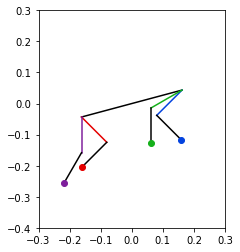

In [5]:
#Plot known values and see if it works. 
X=0.0
Z=0.0
THB=5*pi/12
LB=BodyLength

THH1=pi/4
THK1=-pi/4
LF1=FemurLength
LT1=TibiaLength

THH2=pi/3
THK2=0
LF2=FemurLength
LT2=TibiaLength

THH3=-pi/4
THK3=pi/4
LF3=FemurLength
LT3=TibiaLength

THH4=0
THK4=pi/6
LF4=FemurLength
LT4=TibiaLength

#Convert the symbolic COMs to numerical coordinates
p_b=com_b.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_f1=com_f1.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_t1=com_t1.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_f2=com_f2.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_t2=com_t2.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_f3=com_f3.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_t3=com_t3.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_f4=com_f4.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_t4=com_t4.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])

p_foot1=foot1_pos.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_foot2=foot2_pos.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_foot3=foot3_pos.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])
p_foot4=foot4_pos.subs([(x,X), (z,Z), (th_b, THB),(th_h1, THH1), (th_k1, THK1), (th_h2, THH2),(th_k2, THK2),(th_h3, THH3), (th_k3, THK3), (th_h4, THH4),(th_k4, THK4),
                (l_b,LB),(l_f1,LF1),(l_t1,LT1),(l_f2,LF2),(l_t2,LT2),(l_f3,LF3),(l_t3,LT3),(l_f4,LF4),(l_t4,LT4)])

#Convert these coords to variables
xb=p_b[0]
zb=p_b[1]
thb=THB

xf1=p_f1[0]
zf1=p_f1[1]
thh1a=THH1

xt1=p_t1[0]
zt1=p_t1[1]
thk1a=THK1

xf2=p_f2[0]
zf2=p_f2[1]
thh2a=THH2

xt2=p_t2[0]
zt2=p_t2[1]
thk2a=THK2

xf3=p_f3[0]
zf3=p_f3[1]
thh3a=THH3

xt3=p_t3[0]
zt3=p_t3[1]
thk3a=THK3

xf4=p_f4[0]
zf4=p_f4[1]
thh4a=THH4

xt4=p_t4[0]
zt4=p_t4[1]
thk4a=THK4

#Plotted from the CoM of each link
fig, ax = plt.subplots(1,1) #create axes
ax.set_aspect('equal')
ax.clear()
ax.set_xlim([-0.3,0.3])
ax.set_ylim([-0.4,0.3])

#plot body
legb_xt = xb + 0.5*LB*sym.sin(thb)
legb_zt = zb + 0.5*LB*sym.cos(thb)
legb_xb = xb - 0.5*LB*sym.sin(thb)
legb_zb = zb - 0.5*LB*sym.cos(thb)
ax.plot([legb_xt,legb_xb],[legb_zt,legb_zb],color='xkcd:black')

#Plot Femur 1
legf1_xt = xf1 + 0.5*LF1*sym.sin(thh1a)
legf1_zt = zf1 + 0.5*LF1*sym.cos(thh1a)
legf1_xb = xf1 - 0.5*LF1*sym.sin(thh1a)
legf1_zb = zf1 - 0.5*LF1*sym.cos(thh1a)
ax.plot([legf1_xt,legf1_xb],[legf1_zt,legf1_zb],color='xkcd:blue')

#Plot Tibia 1
legt1_xt = xt1 + 0.5*LT1*sym.sin(thk1a)
legt1_zt = zt1 + 0.5*LT1*sym.cos(thk1a)
legt1_xb = xt1 - 0.5*LT1*sym.sin(thk1a)
legt1_zb = zt1 - 0.5*LT1*sym.cos(thk1a)
ax.plot([legt1_xt,legt1_xb],[legt1_zt,legt1_zb],color='xkcd:black')

#Plot Femur 2
legf2_xt = xf2 + 0.5*LF2*sym.sin(thh2a)
legf2_zt = zf2 + 0.5*LF2*sym.cos(thh2a)
legf2_xb = xf2 - 0.5*LF2*sym.sin(thh2a)
legf2_zb = zf2 - 0.5*LF2*sym.cos(thh2a)
ax.plot([legf2_xt,legf2_xb],[legf2_zt,legf2_zb],color='xkcd:green')

#Plot Tibia 2
legt2_xt = xt2 + 0.5*LT2*sym.sin(thk2a)
legt2_zt = zt2 + 0.5*LT2*sym.cos(thk2a)
legt2_xb = xt2 - 0.5*LT2*sym.sin(thk2a)
legt2_zb = zt2 - 0.5*LT2*sym.cos(thk2a)
ax.plot([legt2_xt,legt2_xb],[legt2_zt,legt2_zb],color='xkcd:black')

#Plot Femur 3
legf3_xt = xf3 + 0.5*LF3*sym.sin(thh3a)
legf3_zt = zf3 + 0.5*LF3*sym.cos(thh3a)
legf3_xb = xf3 - 0.5*LF3*sym.sin(thh3a)
legf3_zb = zf3 - 0.5*LF3*sym.cos(thh3a)
ax.plot([legf3_xt,legf3_xb],[legf3_zt,legf3_zb],color='xkcd:red')

#Plot Tibia 3
legt3_xt = xt3 + 0.5*LT3*sym.sin(thk3a)
legt3_zt = zt3 + 0.5*LT3*sym.cos(thk3a)
legt3_xb = xt3 - 0.5*LT3*sym.sin(thk3a)
legt3_zb = zt3 - 0.5*LT3*sym.cos(thk3a)
ax.plot([legt3_xt,legt3_xb],[legt3_zt,legt3_zb],color='xkcd:black')

#Plot Femur 4
legf4_xt = xf4 + 0.5*LF4*sym.sin(thh4a)
legf4_zt = zf4 + 0.5*LF4*sym.cos(thh4a)
legf4_xb = xf4 - 0.5*LF4*sym.sin(thh4a)
legf4_zb = zf4 - 0.5*LF4*sym.cos(thh4a)
ax.plot([legf4_xt,legf4_xb],[legf4_zt,legf4_zb],color='xkcd:purple')

#Plot Tibia 4
legt4_xt = xt4 + 0.5*LT4*sym.sin(thk4a)
legt4_zt = zt4 + 0.5*LT4*sym.cos(thk4a)
legt4_xb = xt4 - 0.5*LT4*sym.sin(thk4a)
legt4_zb = zt4 - 0.5*LT4*sym.cos(thk4a)
ax.plot([legt4_xt,legt4_xb],[legt4_zt,legt4_zb],color='xkcd:black')

#Plot Feet
ax.plot(p_foot1[0],p_foot1[1],color='xkcd:blue',marker='o')
ax.plot(p_foot2[0],p_foot2[1],color='xkcd:green',marker='o')
ax.plot(p_foot3[0],p_foot3[1],color='xkcd:red',marker='o')
ax.plot(p_foot4[0],p_foot4[1],color='xkcd:purple',marker='o')

In [6]:
# STEP 2: generate expressions for the system space velocities
v_b = com_b.jacobian(q)*dq

v_f1 = com_f1.jacobian(q)*dq
v_t1 = com_t1.jacobian(q)*dq

v_f2 = com_f2.jacobian(q)*dq
v_t2 = com_t2.jacobian(q)*dq

v_f3 = com_f3.jacobian(q)*dq
v_t3 = com_t3.jacobian(q)*dq

v_f4 = com_f4.jacobian(q)*dq
v_t4 = com_t4.jacobian(q)*dq

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()

foot3dx = foot3x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dx = foot3dx[0].simplify()

foot4dx = foot4x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dx = foot4dx[0].simplify()


In [7]:
# STEP 3: generate expressions for the kinetic and potential energy
#Callen Fisher's method, better for bigger problems.
M_b = sym.Matrix([[m_b,m_b]])
M_f1 = sym.Matrix([[m_f1,m_f1]])
M_t1 = sym.Matrix([[m_t1,m_t1]])
M_f2 = sym.Matrix([[m_f2,m_f2]])
M_t2 = sym.Matrix([[m_t2,m_t2]])
M_f3 = sym.Matrix([[m_f3,m_f3]])
M_t3 = sym.Matrix([[m_t3,m_t3]])
M_f4 = sym.Matrix([[m_f4,m_f4]])
M_t4 = sym.Matrix([[m_t4,m_t4]])

I_b=sym.Matrix([[In_b]])
I_f1=sym.Matrix([[In_f1]])
I_t1=sym.Matrix([[In_t1]])
I_f2=sym.Matrix([[In_f2]])
I_t2=sym.Matrix([[In_t2]])
I_f3=sym.Matrix([[In_f3]])
I_t3=sym.Matrix([[In_t3]])
I_f4=sym.Matrix([[In_f4]])
I_t4=sym.Matrix([[In_t4]])

W_b=sym.Matrix([[dth_b]])
W_h1=sym.Matrix([[dth_h1]])
W_k1=sym.Matrix([[dth_k1]])
W_h2=sym.Matrix([[dth_h2]])
W_k2=sym.Matrix([[dth_k2]])
W_h3=sym.Matrix([[dth_h3]])
W_k3=sym.Matrix([[dth_k3]])
W_h4=sym.Matrix([[dth_h4]])
W_k4=sym.Matrix([[dth_k4]])

# linear kinetic energy:
Tl = 0.5*M_b*sym.matrix_multiply_elementwise(v_b,v_b) + 0.5*M_f1*sym.matrix_multiply_elementwise(v_f1,v_f1) + 0.5*M_t1*sym.matrix_multiply_elementwise(v_t1,v_t1) + 0.5*M_f2*sym.matrix_multiply_elementwise(v_f2,v_f2) + 0.5*M_t2*sym.matrix_multiply_elementwise(v_t2,v_t2) + 0.5*M_f3*sym.matrix_multiply_elementwise(v_f3,v_f3) + 0.5*M_t3*sym.matrix_multiply_elementwise(v_t3,v_t3) + 0.5*M_f4*sym.matrix_multiply_elementwise(v_f4,v_f4) + 0.5*M_t4*sym.matrix_multiply_elementwise(v_t4,v_t4)
# angular kinetic energy:
Tw =  0.5*I_b*sym.matrix_multiply_elementwise(W_b,W_b) + 0.5*I_f1*sym.matrix_multiply_elementwise(W_h1,W_h1) + 0.5*I_t1*sym.matrix_multiply_elementwise(W_k1,W_k1) + 0.5*I_f2*sym.matrix_multiply_elementwise(W_h2,W_h2) + 0.5*I_t2*sym.matrix_multiply_elementwise(W_k2,W_k2)+ 0.5*I_f3*sym.matrix_multiply_elementwise(W_h3,W_h3) + 0.5*I_t3*sym.matrix_multiply_elementwise(W_k3,W_k3) + 0.5*I_f4*sym.matrix_multiply_elementwise(W_h4,W_h4) + 0.5*I_t4*sym.matrix_multiply_elementwise(W_k4,W_k4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m_b*g*com_b[1] + m_f1*g*com_f1[1] + m_t1*g*com_t1[1] + m_f2*g*com_f2[1] + m_t2*g*com_t2[1] + m_f3*g*com_f3[1] + m_t3*g*com_t3[1] + m_f4*g*com_f4[1] + m_t4*g*com_t4[1]   


In [8]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))  
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)  
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);  

Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #z
Q[2]=-tau_h1-tau_h2-tau_h3-tau_h4                   #th body
Q[3]=tau_h1-tau_k1              #th hip 1
Q[4]=tau_k1                     #th knee 1
Q[5]=tau_h2-tau_k2              #th hip 2
Q[6]=tau_k2                     #th knee 2
Q[7]=tau_h3-tau_k3              #th hip 3
Q[8]=tau_k3                     #th knee 3
Q[9]=tau_h4-tau_k4              #th hip 4
Q[10]=tau_k4                    #th knee 4

J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2z]])

J3=foot3_pos.jacobian(q)
GRF_3 = J3.transpose()*sym.Matrix([[GRF3x],[GRF3z]]) 

J4=foot4_pos.jacobian(q)
GRF_4 = J4.transpose()*sym.Matrix([[GRF4x],[GRF4z]])

EOM=M*ddq+C*dq+G-Q-GRF_1-GRF_2-GRF_3-GRF_4

EOMs = sym.zeros(len(q),1)
EOMcounter = 0
print(f"EOM simplification starts")
for j in range(len(q)):
    EOMs[j] = EOM[j]#.simplify()  #--> Helps to make simulation faster for bigger problems
    print(f"EOM loop counter: {EOMcounter}")
    EOMcounter = EOMcounter + 1
#display(EOMs[0])


EOM simplification starts
EOM loop counter: 0
EOM loop counter: 1
EOM loop counter: 2
EOM loop counter: 3
EOM loop counter: 4
EOM loop counter: 5
EOM loop counter: 6
EOM loop counter: 7
EOM loop counter: 8
EOM loop counter: 9
EOM loop counter: 10


## Pyomo Stuff Starts

In [9]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4,
            l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4,
            In_b,In_f1,In_t1,In_f2,In_t2,In_f3,In_t3,In_f4,In_t4,
            x,z,th_b,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4,
            dx,dz,dth_b,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4,
            ddx,ddz,ddth_b,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4,
            tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,
            GRF1x,GRF1z,GRF2x,GRF2z,GRF3x,GRF3z,GRF4x,GRF4z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_th_b = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th_h1 = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th_k1 = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th_h2 = sym.lambdify(sym_list,EOMs[5],modules = [func_map])
lambEOM_th_k2 = sym.lambdify(sym_list,EOMs[6],modules = [func_map])
lambEOM_th_h3 = sym.lambdify(sym_list,EOMs[7],modules = [func_map])
lambEOM_th_k3 = sym.lambdify(sym_list,EOMs[8],modules = [func_map])
lambEOM_th_h4 = sym.lambdify(sym_list,EOMs[9],modules = [func_map])
lambEOM_th_k4 = sym.lambdify(sym_list,EOMs[10],modules = [func_map])

lamb_foot1x = sym.lambdify(sym_list,foot1x,modules = [func_map])
lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])

lamb_foot2x = sym.lambdify(sym_list,foot2x,modules = [func_map])
lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])

lamb_foot3x = sym.lambdify(sym_list,foot3x,modules = [func_map])
lamb_foot3z = sym.lambdify(sym_list,foot3z,modules = [func_map])
lamb_foot3dx = sym.lambdify(sym_list,foot3dx,modules = [func_map])

lamb_foot4x = sym.lambdify(sym_list,foot4x,modules = [func_map])
lamb_foot4z = sym.lambdify(sym_list,foot4z,modules = [func_map])
lamb_foot4dx = sym.lambdify(sym_list,foot4dx,modules = [func_map])



In [10]:
# ConcreteModel SETS -------------------------------------------------------------------------------
m.N = RangeSet(N)
m.cN = RangeSet(cN)

# sets can have multidimensional indices
# (probably a little gratuitous for such a simple model, but thought I'd show you anyway)
links = [('body',1),('femur',1),('tibia',1),('femur',2),('tibia',2),('femur',3),('tibia',3),('femur',4),('tibia',4)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','z','theta_b','theta_h1','theta_k1','theta_h2','theta_k2','theta_h3','theta_k3','theta_h4','theta_k4']
m.DOF = Set(initialize = DOFs) # the coordinates for each link

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N, bounds = (0,10))

m.h = Var(m.N, bounds =(tmin,tmax))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]


In [11]:
# Substituting variables into ConcreteModel-----------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81) 

# mass of links
def get_m(n, lb, ln):
    if lb == 'femur':
        return FemurMass
    elif lb == 'body':
        return BodyMass
    else: return TibiaMass
m.m = Param(m.L, initialize = get_m)

mbody = sum(m.m[l] for l in links)
mBW = mbody*m.g.value
# m.m.pprint()
print(f'total body mass: {mbody}')
print(f'total body weight: {mBW}')

# length of links
def get_len(n, lb, ln):
    if lb == 'femur':
        return FemurLength
    elif lb == 'body':
        return BodyLength
    else: return TibiaLength
m.l = Param(m.L, initialize = get_len) 
# m.l.pprint()

#Inertia
def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.l[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia
    
print(f"m.In[('body',1)]: {m.In[('body',1)]}")
print(f"m.In[('femur',1)]: {m.In[('femur',1)]}")
print(f"m.In[('tibia',1)]: {m.In[('tibia',1)]}")

total body mass: 3.120999999999999
total body weight: 30.617009999999993
m.In[('body',1)]: 0.017628677083333336
m.In[('femur',1)]: 0.00024576458333333334
m.In[('tibia',1)]: 8.989866666666667e-05


In [12]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)



In [13]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [14]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Z','THETAb', 'THETAh1','THETAk1', 'THETAh2','THETAk2', 'THETAh3','THETAk3','THETAh4','THETAk4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,300)) # should bound it to 10*mBW
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,300)) # should bound it to 10*m_robot*g
m.GRF3 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,300)) # should bound it to 10*m_robot*g
m.GRF4 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,300)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [15]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_3 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_3 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_3   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_3   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_3   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_3   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_3      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_4 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_4 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_4   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_4   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_4   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_4   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_4      = Var(m.N, m.cN, bounds = (0.0,None)) 

print('Done')

Done


In [16]:
# CONTACTS
# Leg 1 --------------------------------------------------------------------------------------------------------------
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)

def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

#condition
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)

def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

#condition
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_contact_3(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_3[n,c] == lamb_foot3z(*var_list)
m.def_a_contact_3 = Constraint(m.N, m.cN, rule = def_a_contact_3)

def def_b_contact_3(m,n,c):   
    return m.b_contact_3[n,c] == m.GRF3[n,c,'Z','ps']
m.def_b_contact_3 = Constraint(m.N, m.cN, rule = def_b_contact_3)

#condition
def def_contact_3_pr(m,n):
    a_contact_3_pr = m.a_contact_3[n,1] + m.a_contact_3[n,2] + m.a_contact_3[n,3] 
    b_contact_3_pr = m.b_contact_3[n,1] + m.b_contact_3[n,2] + m.b_contact_3[n,3]  
    return a_contact_3_pr*b_contact_3_pr <= m.eps
m.def_contact_3_pr = Constraint(m.N, rule = def_contact_3_pr)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_contact_4(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_4[n,c] == lamb_foot4z(*var_list)
m.def_a_contact_4 = Constraint(m.N, m.cN, rule = def_a_contact_4)

def def_b_contact_4(m,n,c):   
    return m.b_contact_4[n,c] == m.GRF4[n,c,'Z','ps']
m.def_b_contact_4 = Constraint(m.N, m.cN, rule = def_b_contact_4)

#condition
def def_contact_4_pr(m,n):
    a_contact_4_pr = m.a_contact_4[n,1] + m.a_contact_4[n,2] + m.a_contact_4[n,3] 
    b_contact_4_pr = m.b_contact_4[n,1] + m.b_contact_4[n,2] + m.b_contact_4[n,3]  
    return a_contact_4_pr*b_contact_4_pr <= m.eps
m.def_contact_4_pr = Constraint(m.N, rule = def_contact_4_pr)


In [17]:
# FRICTION CONE
# Leg 1 --------------------------------------------------------------------------------------------------------------
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF1[n,c,'Z','ps'] - (m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)

def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)

#condition
def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_friction_2(m,n,c):   
    return m.a_friction_2[n,c] == m.mu*m.GRF2[n,c,'Z','ps'] - (m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)

def def_b_friction_2(m,n,c):   
    return m.b_friction_2[n,c] == m.gamma_2[n,c]
m.def_b_friction_2 = Constraint(m.N, m.cN, rule = def_b_friction_2)

#condition
def def_friction_2_pr(m,n):
    a_friction_2_pr = m.a_friction_2[n,1] + m.a_friction_2[n,2] + m.a_friction_2[n,3] 
    b_friction_2_pr = m.b_friction_2[n,1] + m.b_friction_2[n,2] + m.b_friction_2[n,3]  
    return a_friction_2_pr*b_friction_2_pr <= m.eps
m.def_friction_2_pr = Constraint(m.N, rule = def_friction_2_pr)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_friction_3(m,n,c):   
    return m.a_friction_3[n,c] == m.mu*m.GRF3[n,c,'Z','ps'] - (m.GRF3[n,c,'X','ps'] + m.GRF3[n,c,'X','ng'])
m.def_a_friction_3 = Constraint(m.N, m.cN, rule = def_a_friction_3)

def def_b_friction_3(m,n,c):   
    return m.b_friction_3[n,c] == m.gamma_3[n,c]
m.def_b_friction_3 = Constraint(m.N, m.cN, rule = def_b_friction_3)

#condition
def def_friction_3_pr(m,n):
    a_friction_3_pr = m.a_friction_3[n,1] + m.a_friction_3[n,2] + m.a_friction_3[n,3] 
    b_friction_3_pr = m.b_friction_3[n,1] + m.b_friction_3[n,2] + m.b_friction_3[n,3]  
    return a_friction_3_pr*b_friction_3_pr <= m.eps
m.def_friction_3_pr = Constraint(m.N, rule = def_friction_3_pr)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_friction_4(m,n,c):   
    return m.a_friction_4[n,c] == m.mu*m.GRF4[n,c,'Z','ps'] - (m.GRF4[n,c,'X','ps'] + m.GRF4[n,c,'X','ng'])
m.def_a_friction_4 = Constraint(m.N, m.cN, rule = def_a_friction_4)

def def_b_friction_4(m,n,c):   
    return m.b_friction_4[n,c] == m.gamma_4[n,c]
m.def_b_friction_4 = Constraint(m.N, m.cN, rule = def_b_friction_4)

#condition
def def_friction_4_pr(m,n):
    a_friction_4_pr = m.a_friction_4[n,1] + m.a_friction_4[n,2] + m.a_friction_4[n,3] 
    b_friction_4_pr = m.b_friction_4[n,1] + m.b_friction_4[n,2] + m.b_friction_4[n,3]  
    return a_friction_4_pr*b_friction_4_pr <= m.eps
m.def_friction_4_pr = Constraint(m.N, rule = def_friction_4_pr)


In [18]:
#SLIP
# Leg 1 --------------------------------------------------------------------------------------------------------------
#SLIP POS DIR
def def_a_slip_p_1(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_foot1dx(*var_list)
m.def_a_slip_p_1 = Constraint(m.N, m.cN, rule = def_a_slip_p_1)
def def_b_slip_p_1(m,n,c):   
    return m.b_slip_p_1[n,c] == m.GRF1[n,c,'X','ps']
m.def_b_slip_p_1 = Constraint(m.N, m.cN, rule = def_b_slip_p_1)

#condition
def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

# SLIP NEG DIR
def def_a_slip_n_1(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_foot1dx(*var_list)
m.def_a_slip_n_1 = Constraint(m.N, m.cN, rule = def_a_slip_n_1)
def def_b_slip_n_1(m,n,c):   
    return m.b_slip_n_1[n,c] == m.GRF1[n,c,'X','ng']
m.def_b_slip_n_1 = Constraint(m.N, m.cN, rule = def_b_slip_n_1)

#condition
def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)

# Leg 2 --------------------------------------------------------------------------------------------------------------
#SLIP POS DIR
def def_a_slip_p_2(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_p_2[n,c] ==m.gamma_2[n,c]+lamb_foot2dx(*var_list)
m.def_a_slip_p_2 = Constraint(m.N, m.cN, rule = def_a_slip_p_2)
def def_b_slip_p_2(m,n,c):   
    return m.b_slip_p_2[n,c] == m.GRF2[n,c,'X','ps']
m.def_b_slip_p_2 = Constraint(m.N, m.cN, rule = def_b_slip_p_2)

#condition
def def_slip_p_2_pr(m,n):
    a_slip_p_2_pr = m.a_slip_p_2[n,1] + m.a_slip_p_2[n,2] + m.a_slip_p_2[n,3] 
    b_slip_p_2_pr = m.b_slip_p_2[n,1] + m.b_slip_p_2[n,2] + m.b_slip_p_2[n,3]  
    return a_slip_p_2_pr*b_slip_p_2_pr <= m.eps
m.def_slip_p_2_pr = Constraint(m.N, rule = def_slip_p_2_pr)

# SLIP NEG DIR
def def_a_slip_n_2(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_n_2[n,c] ==m.gamma_2[n,c]-lamb_foot2dx(*var_list)
m.def_a_slip_n_2 = Constraint(m.N, m.cN, rule = def_a_slip_n_2)
def def_b_slip_n_2(m,n,c):   
    return m.b_slip_n_2[n,c] == m.GRF2[n,c,'X','ng']
m.def_b_slip_n_2 = Constraint(m.N, m.cN, rule = def_b_slip_n_2)

#condition
def def_slip_n_2_pr(m,n):
    a_slip_n_2_pr = m.a_slip_n_2[n,1] + m.a_slip_n_2[n,2] + m.a_slip_n_2[n,3] 
    b_slip_n_2_pr = m.b_slip_n_2[n,1] + m.b_slip_n_2[n,2] + m.b_slip_n_2[n,3]  
    return a_slip_n_2_pr*b_slip_n_2_pr <= m.eps
m.def_slip_n_2_pr = Constraint(m.N, rule = def_slip_n_2_pr)

# Leg 3 --------------------------------------------------------------------------------------------------------------
#SLIP POS DIR
def def_a_slip_p_3(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_p_3[n,c] ==m.gamma_3[n,c]+lamb_foot3dx(*var_list)
m.def_a_slip_p_3 = Constraint(m.N, m.cN, rule = def_a_slip_p_3)
def def_b_slip_p_3(m,n,c):   
    return m.b_slip_p_3[n,c] == m.GRF3[n,c,'X','ps']
m.def_b_slip_p_3 = Constraint(m.N, m.cN, rule = def_b_slip_p_3)

#condition
def def_slip_p_3_pr(m,n):
    a_slip_p_3_pr = m.a_slip_p_3[n,1] + m.a_slip_p_3[n,2] + m.a_slip_p_3[n,3] 
    b_slip_p_3_pr = m.b_slip_p_3[n,1] + m.b_slip_p_3[n,2] + m.b_slip_p_3[n,3]  
    return a_slip_p_3_pr*b_slip_p_3_pr <= m.eps
m.def_slip_p_3_pr = Constraint(m.N, rule = def_slip_p_3_pr)

# SLIP NEG DIR
def def_a_slip_n_3(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_n_3[n,c] ==m.gamma_3[n,c]-lamb_foot3dx(*var_list)
m.def_a_slip_n_3 = Constraint(m.N, m.cN, rule = def_a_slip_n_3)
def def_b_slip_n_3(m,n,c):   
    return m.b_slip_n_3[n,c] == m.GRF3[n,c,'X','ng']
m.def_b_slip_n_3 = Constraint(m.N, m.cN, rule = def_b_slip_n_3)

#condition
def def_slip_n_3_pr(m,n):
    a_slip_n_3_pr = m.a_slip_n_3[n,1] + m.a_slip_n_3[n,2] + m.a_slip_n_3[n,3] 
    b_slip_n_3_pr = m.b_slip_n_3[n,1] + m.b_slip_n_3[n,2] + m.b_slip_n_3[n,3]  
    return a_slip_n_3_pr*b_slip_n_3_pr <= m.eps
m.def_slip_n_3_pr = Constraint(m.N, rule = def_slip_n_3_pr)

# Leg 4 --------------------------------------------------------------------------------------------------------------
#SLIP POS DIR
def def_a_slip_p_4(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_p_4[n,c] ==m.gamma_4[n,c]+lamb_foot4dx(*var_list)
m.def_a_slip_p_4 = Constraint(m.N, m.cN, rule = def_a_slip_p_4)
def def_b_slip_p_4(m,n,c):   
    return m.b_slip_p_4[n,c] == m.GRF4[n,c,'X','ps']
m.def_b_slip_p_4 = Constraint(m.N, m.cN, rule = def_b_slip_p_4)

#condition
def def_slip_p_4_pr(m,n):
    a_slip_p_4_pr = m.a_slip_p_4[n,1] + m.a_slip_p_4[n,2] + m.a_slip_p_4[n,3] 
    b_slip_p_4_pr = m.b_slip_p_4[n,1] + m.b_slip_p_4[n,2] + m.b_slip_p_4[n,3]  
    return a_slip_p_4_pr*b_slip_p_4_pr <= m.eps
m.def_slip_p_4_pr = Constraint(m.N, rule = def_slip_p_4_pr)

# SLIP NEG DIR
def def_a_slip_n_4(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return m.a_slip_n_4[n,c] ==m.gamma_4[n,c]-lamb_foot4dx(*var_list)
m.def_a_slip_n_4 = Constraint(m.N, m.cN, rule = def_a_slip_n_4)
def def_b_slip_n_4(m,n,c):   
    return m.b_slip_n_4[n,c] == m.GRF4[n,c,'X','ng']
m.def_b_slip_n_4 = Constraint(m.N, m.cN, rule = def_b_slip_n_4)

#condition
def def_slip_n_4_pr(m,n):
    a_slip_n_4_pr = m.a_slip_n_4[n,1] + m.a_slip_n_4[n,2] + m.a_slip_n_4[n,3] 
    b_slip_n_4_pr = m.b_slip_n_4[n,1] + m.b_slip_n_4[n,2] + m.b_slip_n_4[n,3]  
    return a_slip_n_4_pr*b_slip_n_4_pr <= m.eps
m.def_slip_n_4_pr = Constraint(m.N, rule = def_slip_n_4_pr)


In [19]:
m.tau_h1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_1
m.tau_k1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_1
m.tau_h2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_2
m.tau_k2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_2
m.tau_h3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_3
m.tau_k3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_3
m.tau_h4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_4
m.tau_k4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_4

# Leg 1 --------------------------------------------------------------------------------------------------------------
def def_hip1_motor_model_p(m,n):
    return  m.tau_h1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_b'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_h1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_b'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee1_motor_model_p(m,n):
    return  m.tau_k1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_p = Constraint(m.N, rule = def_knee1_motor_model_p)
def def_knee1_motor_model_n(m,n):
    return  m.tau_k1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_n = Constraint(m.N, rule = def_knee1_motor_model_n)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_hip2_motor_model_p(m,n):
    return  m.tau_h2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_b'])
m.def_hip2_motor_model_p = Constraint(m.N, rule = def_hip2_motor_model_p)
def def_hip2_motor_model_n(m,n):
    return  m.tau_h2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_b'])
m.def_hip2_motor_model_n = Constraint(m.N, rule = def_hip2_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_k2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_k2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_hip3_motor_model_p(m,n):
    return  m.tau_h3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_b'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_h3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_b'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee3_motor_model_p(m,n):
    return  m.tau_k3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_p = Constraint(m.N, rule = def_knee3_motor_model_p)
def def_knee3_motor_model_n(m,n):
    return  m.tau_k3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_n = Constraint(m.N, rule = def_knee3_motor_model_n)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_hip4_motor_model_p(m,n):
    return  m.tau_h4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_b'])
m.def_hip4_motor_model_p = Constraint(m.N, rule = def_hip4_motor_model_p)
def def_hip4_motor_model_n(m,n):
    return  m.tau_h4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_b'])
m.def_hip4_motor_model_n = Constraint(m.N, rule = def_hip4_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_k4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_k4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)


In [20]:
S= 1.0 #BW/m.mTot    
#Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_th_b(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_b(*var_list) == 0
m.EOM_th_b = Constraint(m.N, m.cN, rule = EOM_th_b)

def EOM_th_h1(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_h1(*var_list) == 0
m.EOM_th_h1 = Constraint(m.N, m.cN, rule = EOM_th_h1)

def EOM_th_k1(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_k1(*var_list) == 0
m.EOM_th_k1 = Constraint(m.N, m.cN, rule = EOM_th_k1)

def EOM_th_h2(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_h2(*var_list) == 0
m.EOM_th_h2 = Constraint(m.N, m.cN, rule = EOM_th_h2)

def EOM_th_k2(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_k2(*var_list) == 0
m.EOM_th_k2 = Constraint(m.N, m.cN, rule = EOM_th_k2)

def EOM_th_h3(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_h3(*var_list) == 0
m.EOM_th_h3 = Constraint(m.N, m.cN, rule = EOM_th_h3)

def EOM_th_k3(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_k3(*var_list) == 0
m.EOM_th_k3 = Constraint(m.N, m.cN, rule = EOM_th_k3)

def EOM_th_h4(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_h4(*var_list) == 0
m.EOM_th_h4 = Constraint(m.N, m.cN, rule = EOM_th_h4)

def EOM_th_k4(m,n,c):
    tau_h1_in = S*(m.tau_h1[n])
    tau_k1_in = S*(m.tau_k1[n])
    tau_h2_in = S*(m.tau_h2[n])
    tau_k2_in = S*(m.tau_k2[n])
    tau_h3_in = S*(m.tau_h3[n])
    tau_k3_in = S*(m.tau_k3[n])
    tau_h4_in = S*(m.tau_h4[n])
    tau_k4_in = S*(m.tau_k4[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    Gx3_in = S*(m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gz3_in = S*(m.GRF3[n,c,'Z','ps'])
    Gx4_in = S*(m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gz4_in = S*(m.GRF4[n,c,'Z','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    tau_h1_in,tau_k1_in,tau_h2_in,tau_k2_in,tau_h3_in,tau_k3_in,tau_h4_in,tau_k4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in,Gx3_in,Gz3_in,Gx4_in,Gz4_in]
    return lambEOM_th_k4(*var_list) == 0
m.EOM_th_k4 = Constraint(m.N, m.cN, rule = EOM_th_k4)

In [21]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (-0.5, m.q0[n,'z'], 1.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth_b_Bounds(m,n):
    return (1.37, m.q0[n,'theta_b'], 1.77)
m.setth_b_Bounds = Constraint(m.N, rule=setth_b_Bounds)
def setth_h1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h1'], 1.5)
m.setth_h1_Bounds = Constraint(m.N, rule=setth_h1_Bounds)
def setth_k1_Bounds(m,n):
    return (-2.0, m.q0[n,'theta_k1'], 2.0)
m.setth_k1_Bounds = Constraint(m.N, rule=setth_k1_Bounds)
def setth_h2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h2'], 1.5)
m.setth_h2_Bounds = Constraint(m.N, rule=setth_h2_Bounds)
def setth_k2_Bounds(m,n):
    return (-2.0, m.q0[n,'theta_k2'], 2.0)
m.setth_k2_Bounds = Constraint(m.N, rule=setth_k2_Bounds)
def setth_h3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h3'], 1.5)
m.setth_h3_Bounds = Constraint(m.N, rule=setth_h3_Bounds)
def setth_k3_Bounds(m,n):
    return (-2.0, m.q0[n,'theta_k3'], 2.0)
m.setth_k3_Bounds = Constraint(m.N, rule=setth_k3_Bounds)
def setth_h4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h4'], 1.5)
m.setth_h4_Bounds = Constraint(m.N, rule=setth_h4_Bounds)
def setth_k4_Bounds(m,n):
    return (-2.0, m.q0[n,'theta_k4'], 2.0)
m.setth_k4_Bounds = Constraint(m.N, rule=setth_k4_Bounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdth_b_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_b'],2*m.Wmax)
m.setdth_b_Bounds = Constraint(m.N, rule=setdth_b_Bounds)
def setdth_h1_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_h1'],2*m.Wmax)
m.setdth_h1_Bounds = Constraint(m.N, rule=setdth_h1_Bounds)
def setdth_k1_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_k1'], 2*m.Wmax)
m.setdth_k1_Bounds = Constraint(m.N, rule=setdth_k1_Bounds)
def setdth_h2_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_h2'],2*m.Wmax)
m.setdth_h2_Bounds = Constraint(m.N, rule=setdth_h2_Bounds)
def setdth_k2_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_k2'], 2*m.Wmax)
m.setdth_k2_Bounds = Constraint(m.N, rule=setdth_k2_Bounds)
def setdth_h3_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_h3'],2*m.Wmax)
m.setdth_h3_Bounds = Constraint(m.N, rule=setdth_h3_Bounds)
def setdth_k3_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_k3'], 2*m.Wmax)
m.setdth_k3_Bounds = Constraint(m.N, rule=setdth_k3_Bounds)
def setdth_h4_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_h4'],2*m.Wmax)
m.setdth_h4_Bounds = Constraint(m.N, rule=setdth_h4_Bounds)
def setdth_k4_Bounds(m,n):
    return (-2*m.Wmax, m.dq0[n,'theta_k4'], 2*m.Wmax)
m.setdth_k4_Bounds = Constraint(m.N, rule=setdth_k4_Bounds)


In [22]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = 0.01   
        m.q[n,c,'z'].value  = 0.01
        m.q[n,c,'theta_b'].value = np.random.uniform(np.pi/4,3*np.pi/4)   
        m.q[n,c,'theta_h1'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k1'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
        m.GRF3[n,c,'Z','ps'].value = 0.01
        m.GRF3[n,c,'X','ps'].value = 0.01 
        m.GRF3[n,c,'X','ng'].value = 0.01 
        
        m.GRF4[n,c,'Z','ps'].value = 0.01
        m.GRF4[n,c,'X','ps'].value = 0.01 
        m.GRF4[n,c,'X','ng'].value = 0.01

logger.info("Random seed")

[2023-10-27T09:12:51+0200.0148][INFO ][<ipython-input-22-d60c64c1ec88>] - Random seed


In [23]:
#---------WALKING GAIT MOVING ONE LEG AT A TIME-----------
#Enforce contact order 

def contact_order_1(m,n,c):
    # force other feet to stay on the ground
    if (n>2*N/8):
        return m.GRF1[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

def contact_order_2(m,n,c):
    if (n<4*N/8 or n>6*N/8):
        return m.GRF2[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

def contact_order_3(m,n,c):
    if (n<6*N/8 or n==N):
        return m.GRF3[n,c,'Z','ps'] >=5
    else:
        return Constraint.Skip  
m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)

def contact_order_4(m,n,c):
    if (n<2*N/8 or n>4*N/8):
        return m.GRF4[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

logger.info("Contact order enforced to allow one foot to move at a time")

[2023-10-27T09:12:51+0200.0182][INFO ][<ipython-input-23-4d6a3d4cdf2b>] - Contact order enforced to allow one foot to move at a time


In [24]:
# -----------------------Stepping z_clearance enforced---------------------------
# Linked to: WALKING GAIT MOVING ONE LEG AT A TIME
def step_height_1(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<2):
#         return lamb_foot1z(*var_list) <=0.01
    if (n==N/8):#>=(N/8-1) and n<=(N/8+1)):
        return lamb_foot1z(*var_list) >=z_clearance
#     if (n>=2*N/8):
#         return lamb_foot1z(*var_list) <=0.01
    return Constraint.Skip
m.step_height_1 = Constraint(m.N,m.cN,rule=step_height_1)

def step_height_2(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<4*N/8):
#         return lamb_foot2z(*var_list) <=0.01
    if (n==5*N/8):#>=(5*N/8-1) and n<=(5*N/8+1)):
        return lamb_foot2z(*var_list) >=z_clearance
#     if (n>=6*N/8):
#         return lamb_foot2z(*var_list) <=0.01
    return Constraint.Skip
m.step_height_2 = Constraint(m.N,m.cN,rule=step_height_2)

def step_height_3(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<6*N/8):
#         return lamb_foot3z(*var_list) <=0.01
    if (n==7*N/8):#>=(7*N/8-1) and n<=(7*N/8+1)):
        return lamb_foot3z(*var_list) >=z_clearance
#     if (n==8*N/8):
#         return lamb_foot3z(*var_list) <=0.01
    return Constraint.Skip
m.step_height_3 = Constraint(m.N,m.cN,rule=step_height_3)

def step_height_4(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],
                    m.In[('body',1)],m.In[('femur',1)],m.In[('tibia',1)],m.In[('femur',2)],m.In[('tibia',2)],m.In[('femur',3)],m.In[('tibia',3)],m.In[('femur',4)],m.In[('tibia',4)],
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<=2*N/8):
#         return lamb_foot4z(*var_list) <=0.01
    if (n==3*N/8):#>=(3*N/8-1) and n<=(3*N/8+1)):
        return lamb_foot4z(*var_list) >=z_clearance
#     if (n>=4*N/8):
#         return lamb_foot4z(*var_list) <=0.01
    return Constraint.Skip 
m.step_height_4 = Constraint(m.N,m.cN,rule=step_height_4)

logger.info("Step height enforced at apex node")

[2023-10-27T09:12:51+0200.0279][INFO ][<ipython-input-24-f12246ac75c8>] - Step height enforced at apex node


In [25]:
#Relative Knee Angle Constraints
#Knee 1
def relative_th_k1a(m,n):
    return m.q0[n,'theta_k1']-m.q0[n,'theta_h1'] <= -0.1
m.relative_th_k1a = Constraint(m.N, rule = relative_th_k1a)

def th_h1_constraint(m,n):
    return m.q0[n,'theta_h1'] <= 35/180*pi
m.th_h1_constraint = Constraint(m.N, rule = th_h1_constraint)

#Knee 2
def relative_th_k2a(m,n):
    return m.q0[n,'theta_k2']-m.q0[n,'theta_h2'] <= -0.1 
m.relative_th_k2a = Constraint(m.N, rule = relative_th_k2a)

def th_h2_constraint(m,n):
    return m.q0[n,'theta_h2'] <= 35/180*pi
m.th_h2_constraint = Constraint(m.N, rule = th_h2_constraint)

#Knee 3
def relative_th_k3a(m,n):
    return m.q0[n,'theta_k3']-m.q0[n,'theta_h3'] >= 0.1
m.relative_th_k3a = Constraint(m.N, rule = relative_th_k3a)

def th_h3_constraint(m,n):
    return m.q0[n,'theta_h3'] >= -35/180*pi
m.th_h3_constraint = Constraint(m.N, rule = th_h3_constraint)

#Knee 4
def relative_th_k4a(m,n):
    return m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] >= 0.1
m.relative_th_k4a = Constraint(m.N, rule = relative_th_k4a)

def th_h4_constraint(m,n):
    return m.q0[n,'theta_h4'] >= -35/180*pi
m.th_h4_constraint = Constraint(m.N, rule = th_h4_constraint)

logger.info(">< constraint")
logger.info("m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] >= 0.1, >< and ps,ng signs differ from 3D")
logger.info("return m.q0[n,'theta_h4'] >= -35/180*pi, >< and ps,ng signs differ from 3D")


[2023-10-27T09:12:51+0200.0305][INFO ][<ipython-input-25-79cbf085c6f3>] - >< constraint
[2023-10-27T09:12:51+0200.0308][INFO ][<ipython-input-25-79cbf085c6f3>] - m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] >= 0.1, >< and ps,ng signs differ from 3D
[2023-10-27T09:12:51+0200.0310][INFO ][<ipython-input-25-79cbf085c6f3>] - return m.q0[n,'theta_h4'] >= -35/180*pi, >< and ps,ng signs differ from 3D


In [26]:
# # Hip constraints
# def relative_th_h1(m,n):
#     return m.q0[n,'theta_h1'] - m.q0[n,'theta_b'] <= 30/180*pi
# m.relative_th_h1 = Constraint(m.N, rule = relative_th_h1)

# def relative_th_h2(m,n):
#     return m.q0[n,'theta_h2'] - m.q0[n,'theta_b'] <= 30/180*pi
# m.relative_th_h2 = Constraint(m.N, rule = relative_th_h2)

# def relative_th_h3(m,n):
#     return m.q0[n,'theta_h3'] - m.q0[n,'theta_b'] >= -30/180*pi
# m.relative_th_h3 = Constraint(m.N, rule = relative_th_h3)

# def relative_th_h4(m,n):
#     return m.q0[n,'theta_h4'] - m.q0[n,'theta_b'] >= -30/180*pi
# m.relative_th_h4 = Constraint(m.N, rule = relative_th_h4)

In [27]:
#Steady State
#--------------------------------------------------------------

#initial variables
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

#Final position constraints
def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalXmax(m,n):
    if (n==N) :
        return m.q0[n,'x'] <= m.distance*6
    else:
        return Constraint.Skip
m.finalXmax = Constraint(m.N, rule = finalXmax)
logger.info("Max travel = m.distance*6")

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)

def finalthb(m,n):
    if (n==N) :
        return m.q0[n,'theta_b'] == m.q0[1,'theta_b']
    else:
        return Constraint.Skip
m.finalthb = Constraint(m.N, rule = finalthb)

def finalthh1(m,n):
    if (n==N) :
        return m.q0[n,'theta_h1'] == m.q0[1,'theta_h1']
    else:
        return Constraint.Skip
m.finalthh1 = Constraint(m.N, rule = finalthh1)

def finalthk1(m,n):
    if (n==N) :
        return m.q0[n,'theta_k1'] == m.q0[1,'theta_k1']
    else:
        return Constraint.Skip
m.finalthk1 = Constraint(m.N, rule = finalthk1)

def finalthh2(m,n):
    if (n==N) :
        return m.q0[n,'theta_h2'] == m.q0[1,'theta_h2']
    else:
        return Constraint.Skip
m.finalthh2 = Constraint(m.N, rule = finalthh2)

def finalthk2(m,n):
    if (n==N) :
        return m.q0[n,'theta_k2'] == m.q0[1,'theta_k2']
    else:
        return Constraint.Skip
m.finalthk2 = Constraint(m.N, rule = finalthk2)

def finalthh3(m,n):
    if (n==N) :
        return m.q0[n,'theta_h3'] == m.q0[1,'theta_h3']
    else:
        return Constraint.Skip
m.finalthh3 = Constraint(m.N, rule = finalthh3)

def finalthk3(m,n):
    if (n==N) :
        return m.q0[n,'theta_k3'] == m.q0[1,'theta_k3']
    else:
        return Constraint.Skip
m.finalthk3 = Constraint(m.N, rule = finalthk3)

def finalthh4(m,n):
    if (n==N) :
        return m.q0[n,'theta_h4'] == m.q0[1,'theta_h4']
    else:
        return Constraint.Skip
m.finalthh4 = Constraint(m.N, rule = finalthh4)

def finalthk4(m,n):
    if (n==N) :
        return m.q0[n,'theta_k4'] == m.q0[1,'theta_k4']
    else:
        return Constraint.Skip
m.finalthk4 = Constraint(m.N, rule = finalthk4)



[2023-10-27T09:12:51+0200.0361][INFO ][<ipython-input-27-8a7962725579>] - Max travel = m.distance*6


In [28]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)
logger.info("IPOPT starts")
logger.info("changed to torque cost func")
#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
#     return sum(m.h[n] for n in range(1,N+1))/m.q0[N,'x']
    return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)*m.h[n]) for n in range(1,N+1))/m.q0[N,'x'] #Minimum total actuator force and torque
#     return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
#     return sum(m.h[n]/(m.q0[n+1,'x']-m.q0[n,'x']) for n in range(1,N))
m.Cost = Objective(rule = CostFun)


for i in range(0,6):
    logger.info(f"Eps: {m.eps.value}")
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

[2023-10-27T09:12:51+0200.0390][INFO ][<ipython-input-28-0ef43dfcd6c1>] - IPOPT starts
[2023-10-27T09:12:51+0200.0392][INFO ][<ipython-input-28-0ef43dfcd6c1>] - changed to torque cost func


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    26399

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  71 1.0000000e+000 1.30e+001 1.88e+005  -1.0 1.19e+002   1.8 1.06e-003 5.15e-003h  1
  72 1.0000000e+000 1.29e+001 3.04e+005  -1.0 1.22e+002   1.3 1.57e-002 3.85e-003h  1
  73 1.0000000e+000 1.29e+001 5.56e+005  -1.0 1.21e+002   1.7 1.17e-002 2.91e-003h  1
  74 1.0000000e+000 1.27e+001 4.92e+005  -1.0 1.23e+002   1.2 9.25e-003 1.49e-002h  1
  75 1.0000000e+000 1.27e+001 7.37e+005  -1.0 1.23e+002   1.7 1.26e-002 3.55e-003h  1
  76 1.0000000e+000 1.26e+001 6.84e+005  -1.0 1.25e+002   1.2 8.75e-004 5.65e-003h  1
  77 1.0000000e+000 1.26e+001 8.38e+005  -1.0 1.26e+002   1.6 8.41e-003 2.37e-003h  1
  78 1.0000000e+000 1.26e+001 8.64e+005  -1.0 1.71e+002   1.1 3.11e-003 5.24e-004h  1
  79 1.0000000e+000 1.25e+001 8.36e+005  -1.0 1.27e+002   1.6 2.65e-003 3.71e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.0000000e+000 1.25e+001 7.53e+005  -1.0 1.25e+002   2.0 2.48e-003 3.84e-003h  1
  81 1.0000000e+000 1.24e+001 8.42e+005  -1.0 1.29e+002   1

 159 1.0000000e+000 8.68e+000 2.96e+007  -1.0 1.39e+002   3.1 3.69e-003 8.91e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.0000000e+000 8.66e+000 2.90e+007  -1.0 1.38e+002   2.6 3.25e-004 2.51e-003h  1
 161 1.0000000e+000 8.66e+000 3.25e+007  -1.0 1.39e+002   3.1 6.33e-003 1.10e-004h  1
 162 1.0000000e+000 8.65e+000 3.23e+007  -1.0 1.76e+002   2.6 7.37e-005 7.57e-004f  1
 163 1.0000000e+000 8.65e+000 3.30e+007  -1.0 1.40e+002   3.0 1.45e-003 1.46e-004h  1
 164 1.0000000e+000 8.65e+000 3.29e+007  -1.0 2.58e+004   2.5 1.35e-006 5.64e-006f  1
 165 1.0000000e+000 8.61e+000 3.08e+007  -1.0 1.40e+002   3.0 6.29e-004 5.02e-003h  1
 166 1.0000000e+000 8.60e+000 3.46e+007  -1.0 1.39e+002   3.4 3.61e-003 3.52e-004h  1
 167 1.0000000e+000 8.59e+000 3.68e+007  -1.0 1.40e+002   2.9 7.29e-003 1.70e-003h  1
 168 1.0000000e+000 8.57e+000 3.76e+007  -1.0 1.39e+002   3.3 3.02e-003 2.24e-003h  1
 169 1.0000000e+000 8.56e+000 3.83e+007  -1.0 1.39e+002   2

 246 1.0000000e+000 7.51e+000 9.52e+007  -1.0 1.45e+002   3.2 4.82e-003 4.36e-003h  1
 247 1.0000000e+000 7.50e+000 9.39e+007  -1.0 1.43e+002   3.6 1.00e-004 6.12e-004h  1
 248 1.0000000e+000 7.50e+000 9.38e+007  -1.0 1.43e+002   3.1 1.49e-004 2.45e-004h  1
 249 1.0000000e+000 7.50e+000 1.10e+008  -1.0 1.43e+002   3.5 8.36e-003 6.85e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.0000000e+000 7.49e+000 1.09e+008  -1.0 1.39e+002   3.1 5.73e-005 6.06e-004f  1
 251 1.0000000e+000 7.43e+000 9.38e+007  -1.0 1.43e+002   3.5 1.36e-003 8.82e-003h  1
 252r1.0000000e+000 7.43e+000 1.00e+003   0.9 0.00e+000   3.0 0.00e+000 4.58e-007R  4
 253r1.0000000e+000 2.43e+000 1.67e+003   0.9 5.74e+003    -  2.62e-003 1.28e-003f  1
 254 1.0000000e+000 2.38e+000 1.63e+002  -1.0 7.63e+003    -  7.16e-003 2.33e-002f  1
 255 1.0000000e+000 2.09e+000 1.92e+002  -1.0 2.33e+003    -  7.45e-002 1.34e-001f  1
 256 1.0000000e+000 1.91e+000 1.53e+002  -1.0 1.44e+003    

 333 1.0000000e+000 1.25e-004 8.03e-001  -1.7 7.96e-001  -2.5 1.00e+000 1.00e+000h  1
 334 1.0000000e+000 1.32e-003 3.00e-003  -1.7 2.48e+000  -3.0 1.00e+000 1.00e+000h  1
 335 1.0000000e+000 1.18e-006 1.92e-002  -3.8 5.01e-002  -3.5 1.00e+000 1.00e+000h  1
 336 1.0000000e+000 6.11e-006 1.96e-005  -3.8 1.67e-001  -3.9 1.00e+000 1.00e+000h  1
 337 1.0000000e+000 8.09e-009 1.20e-005  -5.7 6.10e-003  -4.4 1.00e+000 1.00e+000h  1
 338 1.0000000e+000 1.81e-010 2.11e-008  -7.0 9.07e-004  -4.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 338

                                   (scaled)                 (unscaled)
Objective...............:  1.0000000000000000e+000   1.0000000000000000e+000
Dual infeasibility......:  2.1091433875108962e-008   2.1091433875108962e-008
Constraint violation....:  1.8148771374626449e-010   1.8148771374626449e-010
Complementarity.........:  9.1180692736977171e-008   9.1180692736977171e-008
Overall NLP error.......:  9.1180692736977171e-008   9.1180692736977171e-

[2023-10-27T09:14:13+0200.0033][INFO ][<ipython-input-28-0ef43dfcd6c1>] - Eps: 1000.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    91740

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  72 2.0688721e-001 5.31e-001 7.60e-003  -3.8 1.51e+002  -7.9 1.00e+000 1.00e+000H  1
  73 2.0613751e-001 1.07e+000 5.74e-003  -3.8 2.36e+002  -8.4 1.00e+000 1.00e+000h  1
  74 2.0654576e-001 1.85e+000 9.06e-003  -3.8 2.04e+003  -8.9 3.73e-001 1.82e-001h  2
  75 2.0837881e-001 4.19e-001 1.17e-003  -3.8 9.36e+001  -7.6 1.00e+000 1.00e+000h  1
  76 2.1041361e-001 1.02e+000 5.89e-003  -3.8 4.31e+002  -8.1 1.00e+000 4.66e-001h  2
  77 2.1295517e-001 5.95e-001 2.64e-002  -3.8 1.62e+002  -8.5 1.00e+000 1.00e+000h  1
  78 2.1125600e-001 6.96e-001 2.70e-002  -3.8 8.45e+003    -  8.28e-001 4.06e-001h  2
  79 2.0922795e-001 3.15e-001 1.31e-003  -3.8 2.80e+002  -9.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.0983502e-001 1.47e+000 2.98e-003  -3.8 1.34e+003 -10.0 1.00e+000 1.00e+000H  1
  81 2.0661599e-001 5.22e-001 3.32e-003  -3.8 7.88e+002  -9.5 1.00e+000 5.00e-001h  2
  82 2.0234072e-001 1.17e+000 3.61e-004  -3.8 1.22e+003 -10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 3.5841479e-005 2.52e-004 1.77e-007  -7.0 2.37e+001  -9.7 1.00e+000 1.00e+000h  1
 161 3.5457095e-005 3.02e-005 2.12e-008  -7.0 8.79e+000  -9.3 1.00e+000 1.00e+000h  1
 162 3.4451015e-005 2.24e-004 1.59e-007  -7.0 2.56e+001  -9.8 1.00e+000 1.00e+000h  1
 163 3.4123297e-005 3.00e-005 1.92e-008  -7.0 9.49e+000  -9.3 1.00e+000 1.00e+000h  1
 164 3.4001542e-005 4.15e-006 4.26e-009  -7.0 3.54e+000  -8.9 1.00e+000 1.00e+000h  1
 165 3.3956109e-005 5.80e-007 4.25e-009  -7.0 1.33e+000  -8.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 165

                                   (scaled)                 (unscaled)
Objective...............:  6.7925615265214550e-006   3.3956109162355267e-005
Dual infeasibility......:  4.2505752289295059e-009   2.1248684448832372e-008
Constraint violation....:  5.2737918920797711e-007   5.7960598720541157e-007
Complementarity.........:  9.0909090909090915e-008   4.54455804736805

[2023-10-27T09:14:56+0200.0916][INFO ][<ipython-input-28-0ef43dfcd6c1>] - Eps: 100.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    91740

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  71 1.8483510e+000 1.21e-001 8.34e-001  -1.7 3.89e+001  -5.5 1.00e+000 1.00e+000h  1
  72 1.8948913e+000 1.53e-001 1.92e+000  -1.7 1.01e+002  -6.0 1.00e+000 7.54e-001h  1
  73 1.9004063e+000 1.47e-001 2.18e+000  -1.7 1.87e+002  -6.5 1.00e+000 1.00e+000h  1
  74 1.9384092e+000 1.26e-001 5.71e-001  -1.7 3.06e+002  -7.0 1.00e+000 1.00e+000h  1
  75 2.1968020e+000 9.84e+000 3.90e+001  -1.7 1.99e+004    -  4.86e-001 4.40e-001f  1
  76 2.2609629e+000 8.94e+000 3.82e+001  -1.7 1.30e+004    -  1.40e-001 1.14e-001h  1
  77 2.4109092e+000 1.09e+001 2.41e+001  -1.7 9.10e+003    -  3.73e-001 5.25e-001h  1
  78 2.4001752e+000 9.79e-001 4.46e+000  -1.7 3.09e+003    -  1.00e+000 1.00e+000h  1
  79 2.3873091e+000 2.38e-001 4.77e-001  -1.7 2.41e+003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.3844439e+000 5.33e-002 5.17e-002  -1.7 3.74e+002    -  1.00e+000 1.00e+000h  1
  81 2.3848741e+000 7.05e-003 4.24e-003  -1.7 3.09e+001  -7

 159 1.7094408e-004 7.30e-005 9.50e-007  -5.7 2.03e+000  -7.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.7123299e-004 1.74e-004 3.57e-007  -5.7 5.33e+000  -8.0 1.00e+000 1.00e+000h  1
 161 1.7126964e-004 2.32e-005 4.88e-008  -5.7 1.93e+000  -7.6 1.00e+000 1.00e+000h  1
 162 1.7131622e-004 1.74e-004 1.58e-007  -5.7 5.30e+000  -8.1 1.00e+000 1.00e+000h  1
 163 1.7133494e-004 2.34e-005 4.34e-008  -5.7 1.93e+000  -7.6 1.00e+000 1.00e+000h  1
 164 1.7138030e-004 1.79e-004 1.60e-007  -5.7 5.33e+000  -8.1 1.00e+000 1.00e+000h  1
 165 1.7139936e-004 2.41e-005 3.88e-008  -5.7 1.95e+000  -7.7 1.00e+000 1.00e+000h  1
 166 1.7142962e-004 1.83e-004 1.83e-007  -5.7 5.35e+000  -8.2 1.00e+000 1.00e+000h  1
 167 1.7137146e-004 1.06e-003 1.32e-006  -5.7 1.28e+001  -8.7 1.00e+000 1.00e+000h  1
 168 1.7072600e-004 3.75e-003 8.60e-006  -5.7 2.39e+001  -9.1 1.00e+000 1.00e+000h  1
 169 1.7059970e-004 4.06e-004 1.13e-006  -5.7 8.71e+000  -8

[2023-10-27T09:15:44+0200.0797][INFO ][<ipython-input-28-0ef43dfcd6c1>] - Eps: 10.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    91740

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  71 1.4331662e+001 1.65e+001 9.27e+005  -1.0 5.99e+001   0.0 5.82e-002 1.11e-002h  1
  72 1.4609627e+001 1.62e+001 9.02e+005  -1.0 8.52e+001  -0.5 4.47e-003 1.89e-002h  1
  73 1.4678559e+001 1.61e+001 1.02e+006  -1.0 5.90e+001  -0.0 2.83e-002 5.08e-003h  1
  74 1.5301158e+001 1.54e+001 9.82e+005  -1.0 8.59e+001  -0.5 9.67e-003 4.35e-002h  1
  75 1.5320166e+001 1.54e+001 1.17e+006  -1.0 6.50e+001  -0.1 4.72e-002 1.43e-003h  1
  76 1.5371716e+001 1.52e+001 1.16e+006  -1.0 1.03e+002  -0.6 2.32e-002 7.55e-003h  1
  77 1.5525874e+001 1.51e+001 1.31e+006  -1.0 8.22e+001  -0.1 5.75e-002 1.20e-002h  1
  78 1.5792469e+001 1.47e+001 1.09e+006  -1.0 7.40e+001   0.3 8.57e-003 2.32e-002h  1
  79 1.5787263e+001 1.47e+001 1.08e+006  -1.0 4.03e+002  -0.2 1.12e-003 3.43e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.5898008e+001 1.45e+001 1.14e+006  -1.0 7.78e+001   0.2 1.61e-002 9.99e-003h  1
  81 1.6255697e+001 1.41e+001 1.05e+006  -1.0 8.38e+001  -0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.5712077e+001 5.89e+000 6.29e+006  -1.0 9.89e+001   0.9 1.46e-002 5.61e-003h  1
 161 2.5710373e+001 5.89e+000 5.73e+006  -1.0 2.89e+002   0.4 1.14e-002 1.08e-004h  1
 162 2.5964732e+001 5.71e+000 5.28e+006  -1.0 9.93e+001   0.8 2.41e-002 2.94e-002h  1
 163 2.5984060e+001 5.70e+000 4.92e+006  -1.0 9.23e+001   1.3 2.43e-004 2.12e-003h  1
 164 2.6207456e+001 5.52e+000 5.25e+006  -1.0 9.70e+001   0.8 4.85e-002 3.25e-002h  1
 165 2.6300190e+001 5.45e+000 3.69e+006  -1.0 8.85e+001   1.2 5.02e-004 1.17e-002h  1
 166 2.6352229e+001 5.40e+000 3.97e+006  -1.0 9.28e+001   0.7 2.95e-002 9.47e-003h  1
 167 2.6423598e+001 5.35e+000 4.09e+006  -1.0 8.64e+001   1.2 1.11e-002 8.69e-003h  1
 168 2.6460766e+001 5.31e+000 4.13e+006  -1.0 9.12e+001   0.7 1.32e-002 8.37e-003h  1
 169 2.6514436e+001 5.28e+000 3.79e+006  -1.0 8.34e+001   1.1 4.03e-004 5.99e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 248 3.2898719e+001 2.71e+000 1.14e+007  -1.0 3.72e+001   1.4 4.83e-004 8.06e-003h  1
 249 3.2987395e+001 2.68e+000 1.05e+007  -1.0 4.40e+001   0.9 3.83e-002 9.27e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 3.3288818e+001 2.60e+000 9.98e+006  -1.0 3.63e+001   1.3 1.93e-002 3.06e-002h  1
 251 3.3192593e+001 2.59e+000 1.00e+007  -1.0 1.99e+002   0.8 1.53e-003 3.82e-003h  1
 252 3.3205204e+001 2.59e+000 1.05e+007  -1.0 3.47e+001   1.3 7.65e-002 1.40e-003h  1
 253 3.3290126e+001 2.56e+000 9.98e+006  -1.0 3.63e+001   1.7 5.56e-003 9.49e-003h  1
 254 3.3519184e+001 2.50e+000 9.64e+006  -1.0 4.08e+001   1.2 1.90e-003 2.50e-002h  1
 255 3.3641453e+001 2.46e+000 1.05e+007  -1.0 3.94e+001   1.6 2.40e-002 1.37e-002h  1
 256 3.3838095e+001 2.41e+000 9.99e+006  -1.0 3.95e+001   1.2 6.46e-002 2.23e-002h  1
 257 3.3865121e+001 2.40e+000 1.40e+007  -1.0 3.81e+001   1.6 5.60e-002 3.12e-003h  1
 258 3.4214946e+001 2.30e+000 1.39e+007  -1.0 3.88e+001   1

 335 1.8124710e+001 3.61e-002 2.28e+002  -1.7 5.69e+000  -3.1 7.86e-001 1.00e+000f  1
 336 1.3055983e+001 5.09e-002 3.45e+000  -1.7 1.10e+001  -3.6 9.79e-001 1.00e+000h  1
 337 1.0231039e+001 2.12e-001 7.16e+000  -1.7 3.48e+001  -4.1 4.86e-001 6.52e-001h  1
 338 8.6379353e+000 5.07e-002 4.59e+000  -1.7 1.40e+001  -3.7 1.00e+000 1.00e+000h  1
 339 7.8247221e+000 8.02e-002 1.00e+001  -1.7 3.62e+001  -4.1 1.00e+000 6.88e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 7.7064320e+000 7.66e-002 1.08e+001  -1.7 3.40e+002  -4.6 5.61e-002 4.02e-002h  1
 341 6.8424772e+000 8.61e-002 1.71e+000  -1.7 4.12e+001  -4.2 9.72e-001 1.00e+000h  1
 342 6.7088434e+000 1.35e-001 6.50e+000  -1.7 8.08e+003  -4.7 7.22e-003 3.72e-003h  2
 343 6.0568988e+000 2.49e-001 6.95e+000  -1.7 5.31e+001  -4.2 5.95e-001 1.00e+000h  1
 344 5.8725677e+000 3.03e-003 6.04e-001  -1.7 1.75e+000  -2.9 1.00e+000 1.00e+000h  1
 345 5.7625514e+000 5.06e-003 3.45e-001  -1.7 6.08e+000  -3

 422 4.6825466e-005 1.02e-002 4.12e-005  -5.7 3.13e+001  -9.4 1.00e+000 1.00e+000h  1
 423 4.6459522e-005 1.00e-002 1.47e-004  -5.7 1.14e+003  -9.9 5.80e-002 2.14e-002h  3
 424 4.3572243e-005 1.03e-002 9.99e-004  -5.7 1.17e+002 -10.4 1.00e+000 1.81e-001h  3
 425 4.3177702e-005 4.85e-004 3.81e-006  -5.7 9.11e-001  -7.2 1.00e+000 1.00e+000h  1
 426 4.3176913e-005 1.72e-006 1.11e-007  -5.7 2.56e-001  -6.8 1.00e+000 1.00e+000h  1
 427 4.3144235e-005 7.80e-006 1.34e-007  -5.7 4.88e-001  -7.3 1.00e+000 1.00e+000h  1
 428 4.3027950e-005 2.54e-005 2.43e-007  -5.7 6.94e-001  -7.8 1.00e+000 1.00e+000h  1
 429 4.2746583e-005 7.06e-005 1.68e-006  -5.7 1.26e+000  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 4.2637213e-005 5.83e-006 6.89e-008  -5.7 4.39e-001  -7.8 1.00e+000 1.00e+000h  1
 431 4.2340583e-005 2.42e-005 3.20e-007  -5.7 1.26e+000  -8.3 1.00e+000 1.00e+000h  1
 432 4.2233588e-005 2.43e-006 6.28e-007  -5.7 4.66e-001  -7

[2023-10-27T09:17:22+0200.0260][INFO ][<ipython-input-28-0ef43dfcd6c1>] - Eps: 1.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    91740

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  71 8.2578772e-001 1.92e+000 3.75e+000  -2.5 8.64e+002    -  7.54e-001 1.00e+000h  1
  72 6.1307805e-001 1.03e+000 3.90e-001  -2.5 7.50e+002    -  8.92e-001 8.41e-001h  1
  73 5.8626398e-001 9.90e-001 6.97e-001  -2.5 2.13e+003    -  2.17e-001 1.02e-001h  2
  74 5.1225429e-001 3.81e-002 1.59e-001  -2.5 2.68e+001  -6.3 1.00e+000 1.00e+000h  1
  75 4.8150422e-001 4.87e-001 7.65e-002  -2.5 7.92e+001  -6.8 1.00e+000 1.00e+000H  1
  76 4.8186737e-001 1.34e-001 1.52e-001  -2.5 1.52e+001  -5.5 1.00e+000 7.47e-001h  1
  77 4.8237871e-001 1.36e-002 4.93e-002  -2.5 2.17e+001  -5.1 1.00e+000 1.00e+000h  1
  78 4.7187386e-001 9.04e-002 8.79e-001  -2.5 8.33e+002    -  1.00e+000 2.38e-001h  2
  79 4.7126046e-001 2.52e-003 5.39e-003  -2.5 4.98e+000  -5.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.6249236e-001 1.11e+000 2.54e+000  -3.8 5.56e+002    -  5.85e-001 1.00e+000f  1
  81 1.2910807e-001 5.59e-001 1.01e+000  -3.8 1.93e+002    

 159 2.0514475e-004 5.01e-002 3.07e-004  -5.7 1.29e+002  -9.5 8.50e-001 8.28e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.9635141e-004 4.72e-002 2.52e-004  -5.7 2.46e+001  -9.0 1.00e+000 1.00e+000h  1
 161 1.7976491e-004 7.05e-002 1.34e-003  -5.7 1.03e+002  -9.5 7.58e-001 1.00e+000H  1
 162 1.8397399e-004 2.43e-002 6.64e-005  -5.7 4.90e+001  -9.1 1.00e+000 1.00e+000h  1
 163 1.7896414e-004 6.54e-002 3.58e-003  -5.7 1.01e+002  -9.1 1.00e+000 4.87e-001h  2
 164 1.7496612e-004 5.66e-002 2.97e-003  -5.7 4.10e+001  -8.7 1.00e+000 4.89e-001h  2
 165 1.6893252e-004 2.43e-002 1.10e-004  -5.7 1.20e+001  -8.3 1.00e+000 1.00e+000h  1
 166 1.6364060e-004 5.95e-002 5.88e-003  -5.7 5.22e+001  -8.8 9.40e-001 3.38e-001h  2
 167 1.5825606e-004 6.53e-002 2.31e-004  -5.7 1.82e+001  -8.3 1.00e+000 1.00e+000h  1
 168 1.5400105e-004 4.35e-003 2.45e-005  -5.7 1.04e+001  -7.9 1.00e+000 1.00e+000h  1
 169 1.4722798e-004 1.46e-001 4.09e-004  -5.7 5.42e+001  -8

 246 1.6074336e-007 2.77e-006 3.84e-008  -7.0 7.74e-001  -9.0 1.00e+000 1.00e+000h  1
 247 1.6061742e-007 5.51e-009 7.82e-010  -7.0 3.63e-002  -7.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 247

                                   (scaled)                 (unscaled)
Objective...............:  1.6061742115562410e-007   1.6061742115562410e-007
Dual infeasibility......:  7.8165986681380286e-010   7.8165986681380286e-010
Constraint violation....:  5.5062063797350902e-009   5.5062063797350902e-009
Complementarity.........:  9.0909090915545001e-008   9.0909090915545001e-008
Overall NLP error.......:  9.0909090915545001e-008   9.0909090915545001e-008


Number of objective function evaluations             = 326
Number of objective gradient evaluations             = 248
Number of equality constraint evaluations            = 326
Number of inequality constraint evaluations          = 326
Number of equality constraint Jacobian evaluations   = 248
Number of inequality constraint Jacobian ev

[2023-10-27T09:18:18+0200.0014][INFO ][<ipython-input-28-0ef43dfcd6c1>] - Eps: 0.1


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    91740

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  71 1.3237770e+002 1.34e+000 2.22e+006  -1.0 3.89e+001   1.8 3.53e-005 2.76e-003h  1
  72 1.3414016e+002 1.33e+000 2.13e+006  -1.0 4.53e+001   1.3 8.72e-004 7.05e-003h  1
  73 1.3421859e+002 1.33e+000 2.30e+006  -1.0 4.36e+001   1.8 4.64e-003 4.26e-004h  1
  74 1.3595032e+002 1.32e+000 2.24e+006  -1.0 4.40e+001   1.3 2.24e-003 6.60e-003h  1
  75 1.3604686e+002 1.32e+000 2.32e+006  -1.0 4.06e+001   1.7 2.45e-003 5.12e-004h  1
  76 1.3782721e+002 1.31e+000 2.31e+006  -1.0 4.73e+001   1.2 6.25e-003 6.04e-003h  1
  77 1.3804629e+002 1.31e+000 2.35e+006  -1.0 4.36e+001   1.7 2.50e-003 1.19e-003h  1
  78 1.4023905e+002 1.30e+000 2.32e+006  -1.0 4.17e+001   1.2 7.09e-003 8.60e-003h  1
  79 1.4042530e+002 1.29e+000 2.76e+006  -1.0 4.33e+001   1.6 1.64e-002 1.87e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.4115774e+002 1.28e+000 2.70e+006  -1.0 3.73e+001   1.1 3.52e-003 1.04e-002h  1
  81 1.4152465e+002 1.27e+000 3.28e+006  -1.0 3.50e+001   1

 159 1.6650888e+002 8.84e-001 9.11e+006  -1.0 2.79e+001   2.3 6.84e-003 3.40e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.6659111e+002 8.81e-001 9.25e+006  -1.0 3.23e+001   1.8 6.04e-003 2.70e-003h  1
 161 1.6665001e+002 8.80e-001 1.20e+007  -1.0 2.82e+001   2.2 1.55e-002 1.36e-003h  1
 162 1.6702546e+002 8.68e-001 1.14e+007  -1.0 4.03e+001   1.8 3.74e-004 1.34e-002h  1
 163 1.6711308e+002 8.66e-001 1.21e+007  -1.0 2.94e+001   2.2 6.54e-003 2.16e-003h  1
 164 1.6720826e+002 8.61e-001 1.20e+007  -1.0 7.61e+001   1.7 1.47e-004 5.64e-003h  1
 165 1.6724401e+002 8.61e-001 1.38e+007  -1.0 3.49e+001   2.1 1.50e-002 9.07e-004h  1
 166 1.6724940e+002 8.60e-001 1.38e+007  -1.0 2.00e+002   1.7 7.94e-004 1.93e-004h  1
 167 1.6755044e+002 8.55e-001 1.31e+007  -1.0 3.59e+001   2.1 1.86e-003 6.73e-003h  1
 168 1.6755880e+002 8.55e-001 1.56e+007  -1.0 3.54e+001   2.5 6.75e-003 1.75e-004h  1
 169 1.6772867e+002 8.51e-001 1.51e+007  -1.0 3.61e+001   2

 246 1.7428251e+002 6.93e-001 7.70e+007  -1.0 3.54e+001   2.3 7.08e-003 3.10e-003h  1
 247 1.7439431e+002 6.91e-001 7.40e+007  -1.0 3.49e+001   2.7 3.95e-004 3.32e-003h  1
 248 1.7441123e+002 6.91e-001 7.44e+007  -1.0 3.87e+001   2.3 2.26e-002 4.83e-004h  1
 249 1.7481403e+002 6.81e-001 6.46e+007  -1.0 3.62e+001   2.7 2.27e-003 1.34e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.7481970e+002 6.81e-001 6.44e+007  -1.0 4.77e+001   2.2 2.04e-003 2.13e-004h  1
 251 1.7487737e+002 6.80e-001 6.36e+007  -1.0 3.32e+001   2.6 1.33e-003 2.31e-003h  1
 252 1.7488887e+002 6.79e-001 6.29e+007  -1.0 6.57e+001   2.2 2.61e-003 4.39e-004h  1
 253 1.7490322e+002 6.79e-001 6.27e+007  -1.0 2.98e+001   2.6 1.22e-004 5.05e-004h  1
 254 1.7503497e+002 6.78e-001 6.26e+007  -1.0 1.75e+002   2.1 1.85e-003 1.93e-003f  1
 255 1.7535581e+002 6.71e-001 5.95e+007  -1.0 3.03e+001   2.5 3.36e-003 1.06e-002h  1
 256 1.7539126e+002 6.70e-001 6.21e+007  -1.0 2.89e+001   3

 333 1.8070636e+002 5.23e-001 1.44e+008  -1.0 4.69e+001   2.3 1.05e-003 1.52e-003h  1
 334 1.8072952e+002 5.22e-001 1.45e+008  -1.0 4.62e+001   2.8 3.29e-003 2.05e-003h  1
 335 1.8075625e+002 5.19e-001 1.45e+008  -1.0 4.69e+001   2.3 1.30e-002 5.48e-003h  1
 336 1.8079613e+002 5.18e-001 1.41e+008  -1.0 4.41e+001   2.7 6.78e-005 3.73e-003h  1
 337 1.8079423e+002 5.17e-001 1.41e+008  -1.0 8.82e+001   2.2 8.06e-005 9.02e-004h  1
 338 1.8082796e+002 5.16e-001 1.48e+008  -1.0 1.89e+001   2.7 1.15e-002 2.30e-003h  1
 339 1.8090293e+002 5.15e-001 1.47e+008  -1.0 6.46e+001   2.2 3.26e-004 1.91e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.8091089e+002 5.15e-001 1.55e+008  -1.0 1.93e+001   2.6 8.90e-003 5.46e-004h  1
 341 1.8114886e+002 5.13e-001 1.55e+008  -1.0 1.07e+002   2.1 1.15e-003 3.03e-003h  1
 342 1.8124441e+002 5.10e-001 1.56e+008  -1.0 1.97e+001   2.6 9.24e-003 6.77e-003h  1
 343 1.8138346e+002 5.06e-001 1.35e+008  -1.0 1.75e+001   3

 421 1.5160754e+001 2.42e-003 4.53e+000  -1.0 3.31e+000  -2.3 1.00e+000 1.00e+000f  1
 422 1.4778738e+001 7.79e-003 4.32e+000  -1.0 8.60e+000  -2.8 1.00e+000 1.00e+000f  1
 423 1.3811778e+001 5.12e-002 7.42e+000  -1.0 2.41e+001  -3.3 1.00e+000 1.00e+000f  1
 424 1.3419556e+001 2.93e-003 6.52e-001  -1.0 6.81e+000  -2.8 1.00e+000 1.00e+000f  1
 425 1.0388892e+001 3.69e-002 5.24e+002  -1.7 1.18e+001  -3.3 5.35e-001 9.51e-001f  1
 426 8.2720275e+000 6.88e-002 5.46e+002  -1.7 2.02e+001  -3.8 2.49e-001 1.00e+000f  1
 427 6.5948872e+000 9.22e-002 2.57e+002  -1.7 3.96e+001  -4.3 6.22e-001 1.00e+000f  1
 428 5.9396849e+000 8.13e-002 1.77e+002  -1.7 4.63e+001  -4.7 3.09e-001 3.36e-001f  1
 429 4.8238826e+000 4.38e-001 9.51e+001  -1.7 8.83e+001  -5.2 4.60e-001 6.69e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 4.2944122e+000 2.44e-001 3.45e+001  -1.7 4.13e+001  -4.8 9.40e-001 7.68e-001f  1
 431 4.0419179e+000 3.32e-001 6.72e+001  -1.7 4.40e+001  -4

 509 1.4730301e-001 2.60e-003 8.26e-001  -3.8 4.24e+001  -6.7 4.47e-001 4.45e-002h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 1.4720349e-001 2.66e-003 1.93e-001  -3.8 7.12e+000  -6.3 1.00e+000 2.50e-001h  3
 511 1.4700363e-001 4.00e-003 7.11e-001  -3.8 3.12e+001  -6.8 8.57e-001 1.47e-001h  3
 512 1.4691345e-001 4.13e-003 3.52e-001  -3.8 1.16e+001  -6.4 1.00e+000 2.50e-001h  3
 513 1.4686715e-001 4.41e-003 9.02e-001  -3.8 1.19e+002  -6.8 1.96e-001 2.71e-002h  4
 514 1.4683051e-001 3.87e-003 5.51e-001  -3.8 1.93e+001  -6.4 1.00e+000 2.50e-001h  3
 515 1.4652137e-001 3.71e-003 8.79e-001  -3.8 7.85e+001  -6.9 3.65e-001 1.10e-001h  3
 516 1.4600008e-001 3.92e-003 1.35e+000  -3.8 3.49e+001  -6.5 1.00e+000 2.26e-001h  2
 517 1.4537501e-001 2.27e-002 1.35e+000  -3.8 2.95e+003    -  7.05e-002 2.37e-002h  2
 518 1.4312369e-001 1.42e-002 7.64e-002  -3.8 3.10e+001  -6.9 1.00e+000 1.00e+000h  1
 519 1.4177269e-001 4.20e-001 2.33e-001  -3.8 9.22e+001  -7

 596 6.5491591e-002 1.01e-002 4.74e-002  -5.7 1.03e+002  -7.6 8.06e-002 1.27e-001f  1
 597 6.5247617e-002 2.45e-003 5.54e-002  -5.7 5.59e+000  -6.2 5.00e-001 7.69e-001h  1
 598 6.4881643e-002 1.70e-003 6.99e-002  -5.7 1.46e+001  -6.7 9.70e-001 5.91e-001h  1
 599 6.4797670e-002 1.68e-003 5.69e-002  -5.7 2.57e+002  -7.2 2.99e-002 5.23e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 6.4796913e-002 3.71e-004 4.17e-002  -5.7 9.40e-002  -4.0 5.99e-001 7.80e-001f  1
 601 6.4788717e-002 3.16e-007 1.85e-004  -5.7 1.02e-001  -4.5 1.00e+000 1.00e+000f  1
 602 6.4772209e-002 2.04e-006 3.88e-005  -5.7 3.09e-001  -5.0 1.00e+000 1.00e+000h  1
 603 6.4735726e-002 1.83e-005 2.65e-005  -5.7 9.13e-001  -5.5 1.00e+000 1.00e+000h  1
 604 6.4631972e-002 1.46e-004 3.81e-005  -5.7 2.61e+000  -6.0 1.00e+000 1.00e+000h  1
 605 6.4358150e-002 1.04e-003 1.40e-004  -5.7 6.93e+000  -6.4 1.00e+000 1.00e+000h  1
 606 6.3718575e-002 5.35e-003 8.18e-004  -5.7 1.55e+001  -6

 683 5.1674585e-002 4.65e-004 1.44e-002  -7.0 1.20e+001  -6.7 8.22e-001 3.34e-001f  1
 684 5.1672987e-002 4.48e-004 1.13e-001  -7.0 1.53e+001  -7.2 1.00e+000 3.85e-002f  1
 685 5.1626832e-002 2.34e-004 7.37e-002  -7.0 8.46e+001  -7.7 2.68e-001 4.23e-001f  1
 686 5.1612001e-002 1.90e-004 1.01e-001  -7.0 3.94e+001  -7.3 6.29e-001 1.68e-001f  1
 687 5.1561935e-002 2.96e-004 7.97e-002  -7.0 1.73e+002  -7.7 1.12e-001 1.51e-001f  1
 688 5.1528478e-002 2.67e-004 3.73e-002  -7.0 3.40e+001  -7.3 9.76e-001 2.52e-001f  1
 689 5.1502756e-002 1.47e-004 3.32e-002  -7.0 2.63e+001  -7.8 5.37e-001 3.82e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 5.1493138e-002 1.23e-004 5.81e-002  -7.0 2.28e+002  -8.3 1.21e-001 5.64e-002f  1
 691 5.1481658e-002 9.11e-005 5.09e-002  -7.0 1.43e+001  -7.8 5.10e-001 2.57e-001f  1
 692 5.1460262e-002 6.08e-005 2.72e-002  -7.0 4.84e+001  -8.3 1.94e-001 2.78e-001f  1
 693 5.1434627e-002 9.52e-005 3.83e-002  -7.0 2.57e+001  -7

 771 4.9759163e-002 9.48e-004 6.08e-002  -7.0 3.86e+002  -9.9 4.58e-001 1.42e-001h  1
 772 4.9731681e-002 3.60e-003 1.78e-002  -7.0 1.56e+002  -9.5 3.90e-001 8.55e-001f  1
 773 4.9726495e-002 1.02e-003 1.50e-002  -7.0 3.62e+001  -9.0 1.00e+000 4.67e-001f  1
 774 4.9718385e-002 9.06e-004 5.46e-003  -7.0 5.73e+001  -9.5 3.46e-001 4.42e-001f  1
 775 4.9712335e-002 3.01e-004 3.66e-002  -7.0 2.33e+001  -9.1 3.46e-001 1.00e+000f  1
 776 4.9709369e-002 9.51e-005 9.87e-003  -7.0 9.47e+000  -8.7 1.00e+000 8.53e-001h  1
 777 4.9708776e-002 2.31e-005 1.19e-002  -7.0 3.97e+000  -8.2 8.57e-001 1.00e+000f  1
 778 4.9708381e-002 1.32e-005 1.30e-005  -7.0 1.72e+000  -7.8 1.00e+000 1.00e+000h  1
 779 4.9708657e-002 1.35e-004 7.18e-003  -7.0 1.17e+002  -8.3 4.36e-002 5.04e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 4.9707009e-002 3.25e-004 4.10e-002  -7.0 1.42e+001  -7.9 1.00e+000 6.32e-001h  1
 781 4.9704144e-002 6.32e-005 8.64e-006  -7.0 4.07e+000  -7

 859 4.8933712e-002 4.18e-004 3.74e-003  -7.0 1.32e+002 -10.3 1.00e+000 9.18e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 4.8932427e-002 3.09e-004 1.61e-002  -7.0 1.11e+002 -10.8 5.48e-001 4.50e-001f  1
 861 4.8930265e-002 4.75e-004 3.28e-002  -7.0 3.79e+002 -11.3 1.00e+000 7.44e-001f  1
 862 4.8927824e-002 3.56e-004 3.64e-002  -7.0 1.95e+003 -11.8 9.83e-001 2.70e-001f  1
 863 4.8926678e-002 9.07e-004 2.87e-002  -7.0 5.04e+002    -  1.00e+000 6.61e-001f  1
 864 4.8926469e-002 2.78e-005 2.44e-006  -7.0 5.20e+001    -  1.00e+000 1.00e+000f  1
 865 4.8926445e-002 2.56e-006 1.42e-008  -7.0 1.16e+001    -  1.00e+000 1.00e+000h  1
 866 4.8926444e-002 1.23e-010 1.03e-012  -7.0 1.03e-001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 866

                                   (scaled)                 (unscaled)
Objective...............:  4.8926444381830657e-002   4.8926444381830657e-002
Dual infeasibility......:  1.0282257926431319e-012 

[2023-10-27T09:21:35+0200.0813][INFO ][<ipython-input-28-0ef43dfcd6c1>] - Eps: 0.01


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    62169
Number of nonzeros in inequality constraint Jacobian.:     7524
Number of nonzeros in Lagrangian Hessian.............:    91740

Total number of variables............................:    11118
                     variables with only lower bounds:     4320
    

  71 1.2514117e+001 3.08e-001 2.80e+006  -1.0 1.71e+002  -0.2 3.19e-003 1.00e-002h  1
  72 1.2605502e+001 3.07e-001 3.00e+006  -1.0 1.83e+002   0.2 1.89e-002 5.46e-003h  1
  73 1.2706716e+001 3.07e-001 3.00e+006  -1.0 1.70e+003  -0.2 1.34e-003 9.43e-004h  1
  74 1.2776229e+001 3.06e-001 2.94e+006  -1.0 1.94e+002   0.2 4.12e-004 4.30e-003h  1
  75 1.2821181e+001 3.05e-001 3.28e+006  -1.0 1.89e+002   0.6 1.02e-002 2.65e-003h  1
  76 1.3051049e+001 3.01e-001 3.10e+006  -1.0 1.92e+002   0.1 2.83e-004 1.45e-002h  1
  77 1.3058475e+001 3.01e-001 3.48e+006  -1.0 1.80e+002   0.6 1.08e-002 4.39e-004h  1
  78 1.3187890e+001 2.99e-001 3.43e+006  -1.0 1.82e+002   0.1 3.09e-003 8.70e-003h  1
  79 1.3220384e+001 2.98e-001 4.04e+006  -1.0 1.81e+002   0.5 2.35e-002 2.01e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.3309311e+001 2.97e-001 4.05e+006  -1.0 1.77e+002   0.9 5.32e-003 4.97e-003h  1
  81 1.3382298e+001 2.96e-001 3.94e+006  -1.0 1.83e+002   0

 159 1.8305766e+001 2.47e-001 2.09e+008  -1.0 2.01e+002   2.1 3.71e-003 8.03e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.8455865e+001 2.46e-001 2.12e+008  -1.0 2.03e+002   1.6 8.14e-003 4.52e-003h  1
 161 1.8552298e+001 2.46e-001 2.00e+008  -1.0 1.93e+002   2.0 2.42e-005 3.14e-003h  1
 162 1.8558212e+001 2.46e-001 2.20e+008  -1.0 1.79e+002   2.5 2.13e-003 2.02e-004h  1
 163 1.8600686e+001 2.45e-001 2.14e+008  -1.0 1.84e+002   2.0 5.65e-005 1.75e-003h  1
 164 1.8601731e+001 2.45e-001 2.38e+008  -1.0 1.82e+002   2.4 2.76e-003 3.48e-005h  1
 165 1.8579307e+001 2.45e-001 2.34e+008  -1.0 9.37e+002   1.9 5.67e-005 1.22e-003h  1
 166 1.8596068e+001 2.45e-001 2.32e+008  -1.0 1.84e+002   2.4 2.97e-004 5.64e-004h  1
 167 1.8596642e+001 2.45e-001 2.37e+008  -1.0 1.86e+002   1.9 2.55e-003 1.99e-005h  1
 168 1.8661863e+001 2.44e-001 2.29e+008  -1.0 1.84e+002   2.3 9.45e-004 2.20e-003h  1
 169 1.8710014e+001 2.44e-001 2.32e+008  -1.0 1.86e+002   1

 246 1.8512034e+001 6.21e-001 1.64e+007  -1.0 1.56e+001   0.4 8.40e-002 1.97e-002h  1
 247 1.8542565e+001 6.06e-001 1.67e+007  -1.0 3.41e+001  -0.0 6.22e-002 2.46e-002h  1
 248 1.8624690e+001 5.86e-001 1.60e+007  -1.0 5.29e+001  -0.5 8.37e-002 3.18e-002h  1
 249 1.8710841e+001 5.67e-001 1.41e+007  -1.0 5.76e+001  -1.0 1.30e-001 3.29e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.8711334e+001 5.61e-001 1.39e+007  -1.0 1.43e+002  -1.5 1.44e-002 1.14e-002h  1
 251 1.8823705e+001 5.40e-001 1.26e+007  -1.0 5.53e+001  -1.0 9.15e-002 3.60e-002h  1
 252 1.9048631e+001 5.19e-001 1.21e+007  -1.0 5.19e+001  -0.6 4.23e-002 4.00e-002h  1
 253 1.9113567e+001 5.10e-001 1.12e+007  -1.0 7.08e+001  -1.1 8.04e-002 1.75e-002h  1
 254 1.9145933e+001 5.07e-001 1.10e+007  -1.0 1.03e+002  -0.7 4.48e-002 6.25e-003h  1
 255 1.9253744e+001 4.98e-001 1.10e+007  -1.0 1.15e+002  -0.2 2.47e-002 1.72e-002h  1
 256 1.9296376e+001 4.95e-001 1.21e+007  -1.0 1.43e+002  -0

 333 3.2999555e+001 1.39e-001 1.28e+009  -1.0 1.03e+002   2.3 1.21e-003 7.44e-003h  1
 334 3.3072890e+001 1.38e-001 1.50e+009  -1.0 1.03e+002   1.8 1.88e-002 6.17e-003h  1
 335 3.3151880e+001 1.37e-001 1.73e+009  -1.0 1.02e+002   2.2 1.04e-002 6.00e-003h  1
 336 3.3200444e+001 1.36e-001 1.68e+009  -1.0 9.97e+001   1.8 2.31e-003 5.11e-003h  1
 337 3.3278225e+001 1.36e-001 1.66e+009  -1.0 1.01e+002   2.2 5.64e-003 5.88e-003h  1
 338 3.3378171e+001 1.35e-001 1.56e+009  -1.0 1.01e+002   1.7 3.17e-004 7.85e-003h  1
 339 3.3509023e+001 1.33e-001 1.75e+009  -1.0 1.00e+002   2.1 1.48e-002 9.73e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 3.3753776e+001 1.31e-001 1.64e+009  -1.0 1.00e+002   1.7 8.84e-003 1.84e-002h  1
 341 3.3845503e+001 1.30e-001 2.08e+009  -1.0 9.81e+001   2.1 2.02e-002 6.90e-003h  1
 342 3.3923251e+001 1.29e-001 2.04e+009  -1.0 9.84e+001   1.6 2.06e-003 6.22e-003h  1
 343 3.4029526e+001 1.28e-001 2.74e+009  -1.0 9.72e+001   2

 421 3.9801921e+001 7.42e-002 1.21e+010  -1.0 6.18e+001   2.7 5.93e-003 8.08e-003h  1
 422 3.9803848e+001 7.41e-002 1.21e+010  -1.0 1.09e+002   2.3 1.48e-004 6.09e-004h  1
 423 3.9870878e+001 7.35e-002 1.30e+010  -1.0 6.13e+001   2.7 2.50e-002 8.23e-003h  1
 424 3.9865211e+001 7.35e-002 1.30e+010  -1.0 7.66e+002   2.2 7.69e-005 1.41e-004h  1
 425 3.9880275e+001 7.34e-002 1.34e+010  -1.0 6.11e+001   2.6 8.97e-003 1.92e-003h  1
 426 3.9941163e+001 7.28e-002 1.25e+010  -1.0 6.07e+001   3.1 3.50e-003 7.46e-003h  1
 427 3.9959053e+001 7.26e-002 1.27e+010  -1.0 6.06e+001   2.6 1.01e-002 2.32e-003h  1
 428 4.0078240e+001 7.16e-002 1.04e+010  -1.0 6.02e+001   3.0 2.55e-003 1.48e-002h  1
 429 4.0084821e+001 7.15e-002 1.10e+010  -1.0 5.97e+001   2.5 2.13e-002 8.89e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 4.0096248e+001 7.14e-002 1.09e+010  -1.0 5.94e+001   3.0 1.15e-003 1.64e-003h  1
 431 4.0115709e+001 7.12e-002 1.10e+010  -1.0 5.97e+001   2

 509 4.3338566e+001 3.60e-002 3.86e+010  -1.0 3.11e+001   3.2 1.76e-002 1.89e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 4.3373720e+001 3.56e-002 3.86e+010  -1.0 3.10e+001   2.7 1.75e-003 1.00e-002f  1
 511 4.3426021e+001 3.51e-002 3.83e+010  -1.0 3.06e+001   3.2 2.13e-002 1.54e-002h  1
 512 4.3514047e+001 3.41e-002 3.88e+010  -1.0 3.03e+001   2.7 1.92e-003 2.68e-002h  1
 513 4.3539229e+001 3.39e-002 3.90e+010  -1.0 2.94e+001   3.1 3.66e-002 7.92e-003h  1
 514 4.3583393e+001 3.34e-002 3.63e+010  -1.0 2.92e+001   3.5 4.70e-003 1.38e-002h  1
 515 4.3591303e+001 3.33e-002 3.94e+010  -1.0 2.88e+001   4.0 6.47e-003 2.49e-003h  1
 516 4.3634001e+001 3.29e-002 4.19e+010  -1.0 2.88e+001   3.5 3.01e-002 1.36e-002h  1
 517 4.3671899e+001 3.25e-002 3.53e+010  -1.0 2.84e+001   3.9 2.96e-003 1.21e-002h  1
 518 4.3755000e+001 3.16e-002 3.20e+010  -1.0 2.81e+001   3.4 9.85e-003 2.69e-002h  1
 519 4.3790351e+001 3.12e-002 2.70e+010  -1.0 2.73e+001   3

 596 1.2924357e+001 3.61e-004 6.75e+000  -1.7 1.38e+000  -2.2 1.00e+000 1.00e+000f  1
 597 1.2452834e+001 5.08e-005 6.26e+000  -1.7 5.14e-001  -1.8 1.00e+000 1.00e+000f  1
 598 1.2065804e+001 8.93e-005 4.38e+001  -1.7 2.53e+000  -2.2 4.09e-001 3.88e-001f  1
 599 1.1729464e+001 1.21e-004 1.28e+000  -1.7 5.59e-001  -1.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 1.1061785e+001 4.43e-004 2.81e+000  -1.7 1.95e+000  -2.3 1.00e+000 1.00e+000f  1
 601 1.0537804e+001 9.16e-004 1.26e+002  -1.7 4.03e+000  -2.8 5.51e-001 4.89e-001f  1
 602 9.8069913e+000 5.35e-003 1.65e+002  -1.7 9.92e+000  -3.2 5.55e-001 5.33e-001f  1
 603 9.7085075e+000 1.27e-003 3.45e+000  -1.7 8.80e-001  -1.9 1.00e+000 1.00e+000f  1
 604 9.5145554e+000 4.23e-004 1.02e+000  -1.7 1.52e+000  -2.4 1.00e+000 1.00e+000f  1
 605 9.4698841e+000 4.09e-004 1.67e+002  -1.7 1.10e+001  -2.9 1.49e-001 7.20e-002f  2
 606 9.4354494e+000 8.79e-006 7.49e-001  -1.7 2.12e-001  -1

 683 1.5852748e+000 6.83e-002 1.69e+000  -2.5 4.26e+001  -5.8 1.00e+000 1.00e+000h  1
 684 1.5855494e+000 2.86e-002 2.06e+000  -2.5 3.67e+000  -4.4 5.54e-001 5.80e-001h  1
 685 1.5764279e+000 1.56e-003 1.67e-001  -2.5 6.39e+000  -4.9 1.00e+000 1.00e+000h  1
 686 1.5760003e+000 9.05e-006 9.61e-003  -2.5 3.13e-001  -3.6 1.00e+000 1.00e+000h  1
 687 1.4504170e+000 6.52e-003 9.52e+001  -3.8 4.28e+000  -4.1 6.61e-001 8.20e-001f  1
 688 1.2739660e+000 2.21e-002 7.87e+001  -3.8 9.10e+000  -4.5 5.39e-001 9.41e-001h  1
 689 1.1927575e+000 1.41e-002 7.22e+001  -3.8 2.35e+001  -5.0 6.40e-001 4.37e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 1.1070693e+000 2.25e-002 3.16e+001  -3.8 7.66e+000  -4.6 7.68e-001 1.00e+000h  1
 691 1.0759816e+000 1.81e-002 3.38e+001  -3.8 1.99e+001  -5.1 6.99e-001 3.04e-001h  1
 692 1.0360403e+000 6.78e-003 2.76e-001  -3.8 4.88e+000  -4.6 1.00e+000 1.00e+000h  1
 693 1.0018136e+000 8.95e-003 3.99e+001  -3.8 1.38e+001  -5

 771 1.7706344e-001 9.16e-005 7.53e-001  -5.7 3.92e-001  -4.3 1.00e+000 9.72e-001f  1
 772 1.7697135e-001 8.52e-005 3.29e+000  -5.7 1.01e+000  -4.8 2.22e-001 9.25e-002f  1
 773 1.7608514e-001 3.74e-004 8.70e+000  -5.7 2.55e+000  -5.3 7.90e-001 4.42e-001f  1
 774 1.7542430e-001 4.80e-004 5.32e+000  -5.7 7.46e+000  -5.8 5.95e-001 2.31e-001f  1
 775 1.7435829e-001 7.84e-004 2.08e+001  -5.7 1.48e+001  -6.3 6.50e-001 2.44e-001f  1
 776 1.7338628e-001 6.77e-004 1.05e+001  -5.7 6.65e+000  -5.8 1.00e+000 6.36e-001f  1
 777 1.7230218e-001 9.38e-004 1.43e+001  -5.7 1.50e+001  -6.3 1.00e+000 4.26e-001f  1
 778 1.7213048e-001 9.05e-004 1.50e+001  -5.7 8.41e+001  -6.8 1.66e-001 3.50e-002h  1
 779 1.7112471e-001 8.47e-004 1.26e+001  -5.7 9.32e+000  -6.4 1.00e+000 5.34e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 1.7002068e-001 1.34e-003 8.66e+000  -5.7 1.98e+001  -6.8 4.11e-001 3.36e-001h  1
 781 1.6931878e-001 9.68e-004 3.73e+000  -5.7 7.11e+000  -6

 859 1.5357617e-001 1.35e-004 5.05e-004  -7.0 9.27e+001  -8.0 1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 1.5353892e-001 5.14e-004 6.10e-001  -7.0 3.82e+001  -8.5 5.13e-001 1.00e+000h  1
 861 1.5352933e-001 6.17e-004 4.76e-001  -7.0 8.25e+001  -8.9 1.63e-001 1.07e-001h  1
 862 1.5352019e-001 4.77e-004 4.15e-001  -7.0 1.96e+002  -9.4 9.59e-002 5.38e-002f  1
 863 1.5351509e-001 5.05e-004 4.34e-001  -7.0 1.73e+003  -9.9 4.89e-003 1.53e-002h  1
 864 1.5350989e-001 4.77e-004 4.10e-001  -7.0 1.53e+002  -9.5 3.06e-001 6.45e-002f  1
 865 1.5349250e-001 7.05e-004 4.11e-001  -7.0 4.15e+002  -9.9 1.91e-001 1.54e-001f  1
 866 1.5348967e-001 1.74e-005 6.00e-004  -7.0 4.13e+000  -7.7 1.00e+000 1.00e+000f  1
 867 1.5348799e-001 1.16e-005 4.31e-002  -7.0 1.78e+001  -8.2 4.51e-001 3.52e-001h  1
 868 1.5347898e-001 2.62e-004 1.12e-003  -7.0 2.43e+001  -8.7 1.00e+000 1.00e+000f  1
 869 1.5346401e-001 6.71e-004 1.03e-001  -7.0 6.81e+001  -9

ok
optimal
tt0[1]: 4.297951562489466
tt0[N]: 5.764910507657419
duration: 1.4669589451679528s
final distance covered: 0.11277575166036202s
average velocity: 0.07687723779307967
hm: 1s
node 1 duration: 0.010000105753564928
node 2 duration: 0.0260885592707848
node 3 duration: 0.06776191250349733
node 4 duration: 0.026988323633864345
node 5 duration: 0.010001164938691912
node 6 duration: 0.1457431876884177
node 7 duration: 0.01989828407401629
node 8 duration: 0.01004513322389142
node 9 duration: 0.010002045691541402
node 10 duration: 0.010002008148752578
node 11 duration: 0.010000948236293767
node 12 duration: 0.0100007430684963
node 13 duration: 0.19033470960803067
node 14 duration: 0.02818494624809567
node 15 duration: 0.010004950479524108
node 16 duration: 0.09733851273857715
node 17 duration: 0.02103554286325741
node 18 duration: 0.010000008875668825
node 19 duration: 0.010000474249221798
node 20 duration: 0.0355537260489398
node 21 duration: 0.02195553385231993
node 22 duration: 0.010

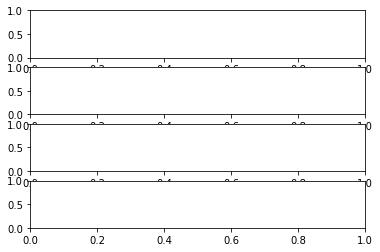

In [29]:
print(results.solver.status) 
print(results.solver.termination_condition) 

# Plotting the stuff --------------------------------------------------
fig, axs = plt.subplots(4)

# Time stuff ----------------------------------------------------------
duration=m.tt0[N].value-m.tt0[1].value
print(f"tt0[1]: {m.tt0[1].value}")
print(f"tt0[N]: {m.tt0[N].value}")
print(f"duration: {duration}s")
print(f"final distance covered: {m.q0[N,'x'].value}s")
print(f"average velocity: {m.q0[N,'x'].value/duration}")
print(f"hm: {hm}s") 

time = np.zeros(N)
sum_x_vel = 0
min_x_vel = 100
max_x_vel = 0

for i in range(1,N+1):
    time[i-1]=m.h[i].value
    sum_x_vel=sum_x_vel+m.dq0[i,'x'].value
    print(f"node {i} duration: {m.h[i].value}")
    if m.dq0[i,'x'].value < min_x_vel:
        min_x_vel=m.dq0[i,'x'].value
    if m.dq0[i,'x'].value > max_x_vel:
        max_x_vel=m.dq0[i,'x'].value

avg_x_vel=sum_x_vel/N
print(f"average x velocity: {avg_x_vel}")
print(f"minimum x velocity: {min_x_vel}")
print(f"maximum x velocity: {max_x_vel}")
    
# axs[0].plot(m.tt0, time)
# axs[0].set_title("time per node")

# # GRF z ps -------------------------------------------------------------
# GRF_1z = np.zeros(N) 
# GRF_2z = np.zeros(N) 
# GRF_3z = np.zeros(N) 
# GRF_4z = np.zeros(N) 
# for i in range(1,N+1):
#     GRF_1z[i-1]=m.GRF1[i,3,'Z','ps'].value
#     GRF_2z[i-1]=m.GRF2[i,3,'Z','ps'].value
#     GRF_3z[i-1]=m.GRF3[i,3,'Z','ps'].value
#     GRF_4z[i-1]=m.GRF4[i,3,'Z','ps'].value
    
# axs[1].plot(m.tt0, GRF_1z)
# axs[1].plot(m.tt0, GRF_2z)
# axs[1].plot(m.tt0, GRF_3z)
# axs[1].plot(m.tt0, GRF_4z)
# axs[1].set_title("GRF in positive z direction")
# axs[1].legend(["GRF_1z", "GRF_2z","GRF_3z", "GRF_4z"])

# # Torques --------------------------------------------------------------
# tau_h1 = np.zeros(N) 
# tau_k1 = np.zeros(N) 
# tau_h2 = np.zeros(N) 
# tau_k2 = np.zeros(N) 
# tau_h3 = np.zeros(N) 
# tau_k3 = np.zeros(N) 
# tau_h4 = np.zeros(N) 
# tau_k4 = np.zeros(N)
# for i in range(1,N+1):
#     tau_h1[i-1]=m.tau_h1[i].value
#     tau_k1[i-1]=m.tau_k1[i].value
#     tau_h2[i-1]=m.tau_h2[i].value
#     tau_k2[i-1]=m.tau_k2[i].value
#     tau_h3[i-1]=m.tau_h3[i].value
#     tau_k3[i-1]=m.tau_k3[i].value
#     tau_h4[i-1]=m.tau_h4[i].value
#     tau_k4[i-1]=m.tau_k4[i].value
    
# axs[2].plot(m.tt0, tau_h1)
# axs[2].plot(m.tt0, tau_k1)
# axs[2].plot(m.tt0, tau_h2)
# axs[2].plot(m.tt0, tau_k2)
# axs[2].plot(m.tt0, tau_h3)
# axs[2].plot(m.tt0, tau_k3)
# axs[2].plot(m.tt0, tau_h4)
# axs[2].plot(m.tt0, tau_k4)
# axs[2].set_title("Torques")
# axs[2].legend(["tau_h1", "tau_k1","tau_h2", "tau_k2","tau_h3", "tau_k3","tau_h4", "tau_k4"],loc='upper right')

# # Velocities --------------------------------------------------------------
# v_x = np.zeros(N) 
# # v_f1 = np.zeros(N)
# # v_t1 = np.zeros(N)
# # v_f2 = np.zeros(N)
# # v_t2 = np.zeros(N)
# # v_f3 = np.zeros(N)
# # v_t3 = np.zeros(N)
# # v_f4 = np.zeros(N)
# # v_t4 = np.zeros(N)
# for i in range(1,N+1):
#     v_x[i-1]=m.dq0[i,'x'].value
# #     v_f1[i-1]=m.dq0[i,'theta_h1'].value
# #     v_t1[[i-1]=m.dq0[i,'theta_h3'].value
# #     v_t3[i-1]=m.dq0[i,'theta_k3'].value
# #     v_f4i-1]=m.dq0[i,'theta_k1'].value
# #     v_f2[i-1]=m.dq0[i,'theta_h2'].value
# #     v_t2[i-1]=m.dq0[i,'theta_k2'].value
# #     v_f3[i-1]=m.dq0[i,'theta_h4'].value
# #     v_t4[i-1]=m.dq0[i,'theta_k4'].value
    
# axs[3].plot(m.tt0, v_x)
# # axs[3].plot(m.tt0, v_f1)
# # axs[3].plot(m.tt0, v_t1)
# # axs[3].plot(m.tt0, v_f2)
# # axs[3].plot(m.tt0, v_t2)
# # axs[3].plot(m.tt0, v_f3)
# # axs[3].plot(m.tt0, v_t3)
# # axs[3].plot(m.tt0, v_f4)
# # axs[3].plot(m.tt0, v_t4)
# axs[3].set_title("Velocities")
# # axs[3].legend(["v_b", "v_f1","v_t1", "v_f2","v_t2", "v_f3","v_t3", "v_f4","v_t4"],loc='upper right')

MovieWriter PillowWriter unavailable; using Pillow instead.


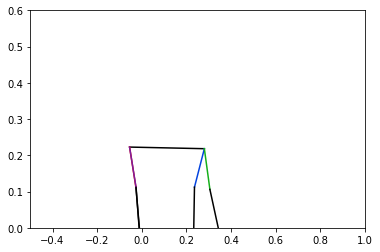

In [30]:
# Animation stuff -------------------------------------------------------
fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0.0,0.6])

    #plot body
    legb_xt = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value)
    legb_zt = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value)
    legb_xb = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value)
    legb_zb = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value)
    ax.plot([legb_xt,legb_xb],[legb_zt,legb_zb],color='xkcd:black')

    #Plot Femur 1
    legf1_xt = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) 
    legf1_zt = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value)
    legf1_xb = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',1)]*sym.sin(m.q0[i,'theta_h1'].value)
    legf1_zb = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',1)]*sym.cos(m.q0[i,'theta_h1'].value)
    ax.plot([legf1_xt,legf1_xb],[legf1_zt,legf1_zb],color='xkcd:blue')

    #Plot Tibia 1
    legt1_xb = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',1)]*sym.sin(m.q0[i,'theta_h1'].value) - m.l[('tibia',1)]*sym.sin(m.q0[i,'theta_k1'].value)
    legt1_zb = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',1)]*sym.cos(m.q0[i,'theta_h1'].value) - m.l[('tibia',1)]*sym.cos(m.q0[i,'theta_k1'].value)
    ax.plot([legf1_xb,legt1_xb],[legf1_zb,legt1_zb],color='xkcd:black')

    #Plot Femur 2
    legf2_xt = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) 
    legf2_zt = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value)
    legf2_xb = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',2)]*sym.sin(m.q0[i,'theta_h2'].value)
    legf2_zb = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',2)]*sym.cos(m.q0[i,'theta_h2'].value)
    ax.plot([legf2_xt,legf2_xb],[legf2_zt,legf2_zb],color='xkcd:green')

    #Plot Tibia 2
    legt2_xb = m.q0[i,'x'].value + 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',2)]*sym.sin(m.q0[i,'theta_h2'].value) - m.l[('tibia',2)]*sym.sin(m.q0[i,'theta_k2'].value)
    legt2_zb = m.q0[i,'z'].value + 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',2)]*sym.cos(m.q0[i,'theta_h2'].value) - m.l[('tibia',2)]*sym.cos(m.q0[i,'theta_k2'].value)
    ax.plot([legf2_xb,legt2_xb],[legf2_zb,legt2_zb],color='xkcd:black')

    #Plot Femur 3
    legf3_xt = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) 
    legf3_zt = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value)
    legf3_xb = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',3)]*sym.sin(m.q0[i,'theta_h3'].value)
    legf3_zb = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',3)]*sym.cos(m.q0[i,'theta_h3'].value)
    ax.plot([legf3_xt,legf3_xb],[legf3_zt,legf3_zb],color='xkcd:red')

    #Plot Tibia 3
    legt3_xb = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',3)]*sym.sin(m.q0[i,'theta_h3'].value) - m.l[('tibia',3)]*sym.sin(m.q0[i,'theta_k3'].value)
    legt3_zb = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',3)]*sym.cos(m.q0[i,'theta_h3'].value) - m.l[('tibia',3)]*sym.cos(m.q0[i,'theta_k3'].value)
    ax.plot([legf3_xb,legt3_xb],[legf3_zb,legt3_zb],color='xkcd:black')
    
    #Plot Femur 4
    legf4_xt = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) 
    legf4_zt = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value)
    legf4_xb = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',4)]*sym.sin(m.q0[i,'theta_h4'].value)
    legf4_zb = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',4)]*sym.cos(m.q0[i,'theta_h4'].value)
    ax.plot([legf4_xt,legf4_xb],[legf4_zt,legf4_zb],color='xkcd:purple')

    #Plot Tibia 4
    legt4_xb = m.q0[i,'x'].value - 0.5*m.l[('body',1)]*sym.sin(m.q0[i,'theta_b'].value) - m.l[('femur',4)]*sym.sin(m.q0[i,'theta_h4'].value) - m.l[('tibia',4)]*sym.sin(m.q0[i,'theta_k4'].value)
    legt4_zb = m.q0[i,'z'].value - 0.5*m.l[('body',1)]*sym.cos(m.q0[i,'theta_b'].value) - m.l[('femur',4)]*sym.cos(m.q0[i,'theta_h4'].value) - m.l[('tibia',4)]*sym.cos(m.q0[i,'theta_k4'].value)
    ax.plot([legf4_xb,legt4_xb],[legf4_zb,legt4_zb],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = m.h[i].value*hm*1000,repeat=False)
# m.h[i].value*hm*100000
animate.save(r"C:"+path+gait_name+".gif", writer='PillowWriter', fps=10)


HTML(animate.to_jshtml())

In [31]:
#SAVING PARAMETERS
import pandas as pd
#Physical properties -----------------------------------------------------------------------------------------------
properties = {'N':[N],'Body Mass':[m.m[('body',1)]],'Femur 1 Mass':[m.m[('femur',1)]],'Tibia 1 Mass':[m.m[('tibia',1)]],'Femur 2 Mass':[m.m[('femur',2)]],
                                    'Tibia 2 Mass':[m.m[('tibia',2)]],'Femur 3 Mass':[m.m[('femur',3)]],'Tibia 3 Mass':[m.m[('tibia',3)]],'Femur 4 Mass':[m.m[('femur',4)]],'Tibia 4 Mass':[m.m[('tibia',4)]],
                                    'Body Length':[m.l[('body',1)]],'Femur 1 Length':[m.l[('femur',1)]],'Tibia 1 Length':[m.l[('tibia',1)]],'Femur 2 Length':[m.l[('femur',2)]],'Tibia 2 Length':[m.l[('tibia',2)]],
                                    'Femur 3 Length':[m.l[('femur',3)]],'Tibia 3 Length':[m.l[('tibia',3)]],'Femur 4 Length':[m.l[('femur',4)]],'Tibia 4 Length':[m.l[('tibia',4)]]}
Properties = pd.DataFrame(properties)
Properties.to_csv (r"C:"+path+gait_name+"_Properties.csv", index = False, header=True)

#Torques, node time steps ------------------------------------------------------------------------------------------------------------
foot_1z = [0 for x in range(N)]
foot_2z = [0 for x in range(N)]
foot_3z = [0 for x in range(N)]
foot_4z = [0 for x in range(N)]

for n in range(1,N+1):
    i=n-1
    foot_1z[i]=(m.a_contact_1[n,1].value+m.a_contact_1[n,2].value+m.a_contact_1[n,3].value)/3
    foot_2z[i]=(m.a_contact_2[n,1].value+m.a_contact_2[n,2].value+m.a_contact_2[n,3].value)/3
    foot_3z[i]=(m.a_contact_3[n,1].value+m.a_contact_3[n,2].value+m.a_contact_3[n,3].value)/3
    foot_4z[i]=(m.a_contact_4[n,1].value+m.a_contact_4[n,2].value+m.a_contact_4[n,3].value)/3
    

torques = {'Node timesteps':[m.h[n].value for n in range (1, N+1)],'Torque Hip 1':[m.tau_h1[n].value for n in range (1, N+1)],'Torque Knee 1':[m.tau_k1[n].value for n in range (1, N+1)],'Torque Hip 2':[m.tau_h2[n].value for n in range (1, N+1)],'Torque Knee 2':[m.tau_k2[n].value for n in range (1, N+1)],
            'Torque Hip 3':[m.tau_h3[n].value for n in range (1, N+1)],'Torque Knee 3':[m.tau_k3[n].value for n in range (1, N+1)],'Torque Hip 4':[m.tau_h4[n].value for n in range (1, N+1)],'Torque Knee 4':[m.tau_k4[n].value for n in range (1, N+1)],
          'Foot 1 lift':[foot_1z[n] for n in range(N)],'Foot 2 lift':[foot_2z[n] for n in range(N)],'Foot 3 lift':[foot_3z[n] for n in range(N)],'Foot 4 lift':[foot_4z[n] for n in range(N)]}
Torques = pd.DataFrame(torques)
Torques.to_csv (r"C:"+path+gait_name+"_Nodal.csv", index = False, header=True)

#Trajectories per collocation point - Angles, Velocities and GRFs - unaltered ----------------------------------------------------------------------------------------
qx = [0 for x in range(N*3)]
qz = [0 for x in range(N*3)]
qb = [0 for x in range(N*3)]
qh1 = [0 for x in range(N*3)]
qk1 = [0 for x in range(N*3)]
qh2 = [0 for x in range(N*3)]
qk2 = [0 for x in range(N*3)]
qh3 = [0 for x in range(N*3)]
qk3 = [0 for x in range(N*3)]
qh4 = [0 for x in range(N*3)]
qk4 = [0 for x in range(N*3)]

dqx = [0 for x in range(N*3)]
dqz = [0 for x in range(N*3)]
dqb = [0 for x in range(N*3)]
dqh1 = [0 for x in range(N*3)]
dqk1 = [0 for x in range(N*3)]
dqh2 = [0 for x in range(N*3)]
dqk2 = [0 for x in range(N*3)]
dqh3 = [0 for x in range(N*3)]
dqk3 = [0 for x in range(N*3)]
dqh4 = [0 for x in range(N*3)]
dqk4 = [0 for x in range(N*3)]

grf1x = [0 for x in range(N*3)]
grf1z = [0 for x in range(N*3)]
grf2x = [0 for x in range(N*3)]
grf2z = [0 for x in range(N*3)]
grf3x = [0 for x in range(N*3)]
grf3z = [0 for x in range(N*3)]
grf4x = [0 for x in range(N*3)]
grf4z = [0 for x in range(N*3)]

for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        qx[i] = m.q[n,c+1,'x'].value
        qz[i] = m.q[n,c+1,'z'].value
        qb[i] = m.q[n,c+1,'theta_b'].value
        qh1[i] = m.q[n,c+1,'theta_h1'].value
        qk1[i] = m.q[n,c+1,'theta_k1'].value
        qh2[i] = m.q[n,c+1,'theta_h2'].value
        qk2[i] = m.q[n,c+1,'theta_k2'].value
        qh3[i] = m.q[n,c+1,'theta_h3'].value
        qk3[i] = m.q[n,c+1,'theta_k3'].value
        qh4[i] = m.q[n,c+1,'theta_h4'].value
        qk4[i] = m.q[n,c+1,'theta_k4'].value
        
        dqx[i] = m.dq[n,c+1,'x'].value
        dqz[i] = m.dq[n,c+1,'z'].value
        dqb[i] = m.dq[n,c+1,'theta_b'].value
        dqh1[i] = m.dq[n,c+1,'theta_h1'].value
        dqk1[i] = m.dq[n,c+1,'theta_k1'].value
        dqh2[i] = m.dq[n,c+1,'theta_h2'].value
        dqk2[i] = m.dq[n,c+1,'theta_k2'].value
        dqh3[i] = m.dq[n,c+1,'theta_h3'].value
        dqk3[i] = m.dq[n,c+1,'theta_k3'].value
        dqh4[i] = m.dq[n,c+1,'theta_h4'].value
        dqk4[i] = m.dq[n,c+1,'theta_k4'].value
        
        grf1x[i] = m.GRF1[n,c+1,'X','ps'].value-m.GRF1[n,c+1,'X','ng'].value
        grf1z[i] = m.GRF1[n,c+1,'Z','ps'].value
        grf2x[i] = m.GRF2[n,c+1,'X','ps'].value-m.GRF2[n,c+1,'X','ng'].value
        grf2z[i] = m.GRF2[n,c+1,'Z','ps'].value
        grf3x[i] = m.GRF3[n,c+1,'X','ps'].value-m.GRF3[n,c+1,'X','ng'].value
        grf3z[i] = m.GRF3[n,c+1,'Z','ps'].value
        grf4x[i] = m.GRF4[n,c+1,'X','ps'].value-m.GRF4[n,c+1,'X','ng'].value
        grf4z[i] = m.GRF4[n,c+1,'Z','ps'].value

movement_traj = {'X Position':[qx[i] for i in range (len(qx))],'Z Position':[qz[i] for i in range (len(qz))],'Body Angle':[qb[i] for i in range (len(qb))],'Hip 1 Angle':[qh1[i] for i in range (len(qh1))],'Knee 1 Angle':[qk1[i] for i in range (len(qk1))],'Hip 2 Angle':[qh2[i] for i in range (len(qh2))],'Knee 2 Angle':[qk2[i] for i in range (len(qk2))],
           'Hip 3 Angle':[qh3[i] for i in range (len(qh3))],'Knee 3 Angle':[qk3[i] for i in range (len(qk3))],'Hip 4 Angle':[qh4[i] for i in range (len(qh4))],'Knee 4 Angle':[qk4[i] for i in range (len(qk4))],
           'X Velocity':[dqx[i] for i in range (len(dqx))],'Z Velocity':[dqz[i] for i in range (len(dqz))],'Body Velocity':[dqb[i] for i in range (len(dqb))],'Hip 1 Velocity':[dqh1[i] for i in range (len(dqh1))],'Knee 1 Velocity':[dqk1[i] for i in range (len(dqk1))],'Hip 2 Velocity':[dqh2[i] for i in range (len(dqh2))],'Knee 2 Velocity':[dqk2[i] for i in range (len(dqk2))],
           'Hip 3 Velocity':[dqh3[i] for i in range (len(dqh3))],'Knee 3 Velocity':[dqk3[i] for i in range (len(dqk3))],'Hip 4 Velocity':[dqh4[i] for i in range (len(dqh4))],'Knee 4 Velocity':[dqk4[i] for i in range (len(dqk4))],
           'GRF 1x':[grf1x[i] for i in range (len(grf1x))],'GRF 2x':[grf2x[i] for i in range (len(grf2x))],'GRF 3x':[grf3x[i] for i in range (len(grf3x))],'GRF 4x':[grf4x[i] for i in range (len(grf4x))],
           'GRF 1z':[grf1z[i] for i in range (len(grf1z))],'GRF 2z':[grf2z[i] for i in range (len(grf2z))],'GRF 3z':[grf3z[i] for i in range (len(grf3z))],'GRF 4z':[grf4z[i] for i in range (len(grf4z))]}

Movement_traj = pd.DataFrame(movement_traj)
Movement_traj.to_csv (r"C:"+path+gait_name+"_col_traj.csv", index = False, header=True)

#ROS trajectories per collocation point  - Angles, Velocities and GRFs - altered ----------------------------------------------------------------------------------------
r_qx = [0 for x in range(N*3)]
r_qz = [0 for x in range(N*3)]
r_qb = [0 for x in range(N*3)]
r_qh1 = [0 for x in range(N*3)]
r_qk1 = [0 for x in range(N*3)]
r_qh2 = [0 for x in range(N*3)]
r_qk2 = [0 for x in range(N*3)]
r_qh3 = [0 for x in range(N*3)]
r_qk3 = [0 for x in range(N*3)]
r_qh4 = [0 for x in range(N*3)]
r_qk4 = [0 for x in range(N*3)]
t = [0 for x in range(N*3)]
t_new = [0 for x in range(N*3)]


for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        r_qx[i] = m.q[n,c+1,'x'].value
        r_qz[i] = m.q[n,c+1,'z'].value
        r_qb[i] = m.q[n,c+1,'theta_b'].value
        r_qh1[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_h1'].value
        r_qk1[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_k1'].value-m.q[n,c+1,'theta_h1'].value
        r_qh2[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_h2'].value
        r_qk2[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_k2'].value-m.q[n,c+1,'theta_h2'].value
        r_qh3[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_h3'].value
        r_qk3[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_k3'].value-m.q[n,c+1,'theta_h3'].value
        r_qh4[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_h4'].value
        r_qk4[i] = pi/2 - m.q[n,c+1,'theta_b'].value + m.q[n,c+1,'theta_k4'].value-m.q[n,c+1,'theta_h4'].value
        t[i] = m.tt[n,c+1].value
 
for n in range (1,len(t)):
    t_new[n]=t[n]-t[n-1]
t_new[0]=m.h[1].value/3

movement_ros = {'X Position':[r_qx[i] for i in range (len(r_qx))],'Z Position':[r_qz[i] for i in range (len(r_qz))],'Body Angle':[r_qb[i] for i in range (len(r_qb))],'Hip 1 Angle':[r_qh1[i] for i in range (len(r_qh1))],'Knee 1 Angle':[r_qk1[i] for i in range (len(r_qk1))],'Hip 2 Angle':[r_qh2[i] for i in range (len(r_qh2))],'Knee 2 Angle':[r_qk2[i] for i in range (len(r_qk2))],
           'Hip 3 Angle':[r_qh3[i] for i in range (len(r_qh3))],'Knee 3 Angle':[r_qk3[i] for i in range (len(r_qk3))],'Hip 4 Angle':[r_qh4[i] for i in range (len(r_qh4))],'Knee 4 Angle':[r_qk4[i] for i in range (len(r_qk4))],'m.tt':[t_new[i] for i in range (len(t))]}

Movement_ros = pd.DataFrame(movement_ros)
Movement_ros.to_csv (r"C:"+path+gait_name+"_col_ros.csv", index = False, header=True)


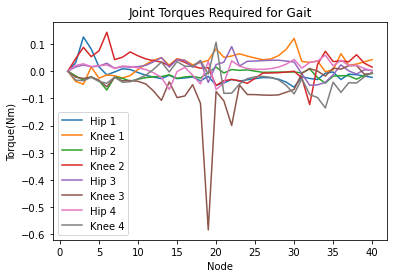

In [32]:
test1 = np.zeros(N)
test2 = np.zeros(N)
test3 = np.zeros(N)
test4 = np.zeros(N)
test5 = np.zeros(N)
test6 = np.zeros(N)
test7 = np.zeros(N)
test8 = np.zeros(N)

for n in range(1,N):
    test1[n]=m.tau_h1[n].value
    test2[n]=m.tau_k1[n].value 
    test3[n]=m.tau_h2[n].value
    test4[n]=m.tau_k2[n].value
    test5[n]=m.tau_h3[n].value
    test6[n]=m.tau_k3[n].value
    test7[n]=m.tau_h4[n].value
    test8[n]=m.tau_k4[n].value

plt.plot(range(1,N+1),test1)
plt.plot(range(1,N+1),test2)
plt.plot(range(1,N+1),test3)
plt.plot(range(1,N+1),test4)
plt.plot(range(1,N+1),test5)
plt.plot(range(1,N+1),test6)
plt.plot(range(1,N+1),test7)
plt.plot(range(1,N+1),test8)
plt.legend(["Hip 1","Knee 1", "Hip 2", "Knee 2","Hip 3","Knee 3", "Hip 4", "Knee 4"])
plt.title('Joint Torques Required for Gait')
plt.xlabel('Node')
plt.ylabel('Torque(Nm)')
plt.savefig(r"C:"+path+gait_name+"_torque.png")

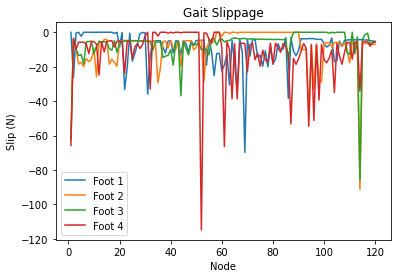

In [33]:
slip_1 = [0 for x in range(N*3)]
slip_2 = [0 for x in range(N*3)]
slip_3 = [0 for x in range(N*3)]
slip_4 = [0 for x in range(N*3)]

for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        slip_1[i] = m.GRF1[n,c+1,'X','ps'].value-m.GRF1[n,c+1,'X','ng'].value-m.GRF1[n,c+1,'Z','ps'].value
        slip_2[i] = m.GRF2[n,c+1,'X','ps'].value-m.GRF2[n,c+1,'X','ng'].value-m.GRF2[n,c+1,'Z','ps'].value
        slip_3[i] = m.GRF3[n,c+1,'X','ps'].value-m.GRF3[n,c+1,'X','ng'].value-m.GRF3[n,c+1,'Z','ps'].value
        slip_4[i] = m.GRF4[n,c+1,'X','ps'].value-m.GRF4[n,c+1,'X','ng'].value-m.GRF4[n,c+1,'Z','ps'].value

plt.plot(range(1,N*3+1),slip_1)
plt.plot(range(1,N*3+1),slip_2)
plt.plot(range(1,N*3+1),slip_3)
plt.plot(range(1,N*3+1),slip_4)
plt.legend(["Foot 1","Foot 2", "Foot 3", "Foot 4"])
plt.title('Gait Slippage')
plt.xlabel('Node')
plt.ylabel('Slip (N)')
plt.savefig(r"C:"+path+gait_name+"_slip.png")

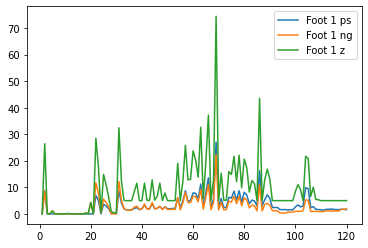

In [38]:
slip_1_ps = [0 for x in range(N*3)]
slip_2_ps = [0 for x in range(N*3)]
slip_3_ps = [0 for x in range(N*3)]
slip_4_ps = [0 for x in range(N*3)]
slip_1_ng = [0 for x in range(N*3)]
slip_2_ng = [0 for x in range(N*3)]
slip_3_ng = [0 for x in range(N*3)]
slip_4_ng = [0 for x in range(N*3)]
slip_1_z  = [0 for x in range(N*3)]

for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        slip_1_ps[i] = m.GRF1[n,c+1,'X','ps'].value
        slip_1_ng[i] = m.GRF1[n,c+1,'X','ng'].value
        slip_1_z[i] = m.GRF1[n,c+1,'Z','ps'].value
        slip_2_ps[i] = m.GRF2[n,c+1,'X','ps'].value
        slip_2_ng[i] = m.GRF2[n,c+1,'X','ng'].value
        slip_3_ps[i] = m.GRF3[n,c+1,'X','ps'].value
        slip_3_ng[i] = m.GRF3[n,c+1,'X','ng'].value
        slip_4_ps[i] = m.GRF4[n,c+1,'X','ps'].value
        slip_4_ng[i] = m.GRF4[n,c+1,'X','ng'].value

plt.plot(range(1,3*N+1),slip_1_ps)
plt.plot(range(1,3*N+1),slip_1_ng)
plt.plot(range(1,3*N+1),slip_1_z)
# plt.plot(range(1,3*N+1),slip_2_ps)
# plt.plot(range(1,3*N+1),slip_2_ng)
# plt.plot(range(1,3*N+1),slip_3_ps)
# plt.plot(range(1,3*N+1),slip_3_ng)
# plt.plot(range(1,3*N+1),slip_4_ps)
# plt.plot(range(1,3*N+1),slip_4_ng)   
# plt.legend(["Foot 1 ps", "Foot 1 ng","Foot 2 ps", "Foot 2 ng","Foot 3 ps", "Foot 3 ng","Foot 4 ps", "Foot 4 ng"])
plt.legend(["Foot 1 ps", "Foot 1 ng", "Foot 1 z"])

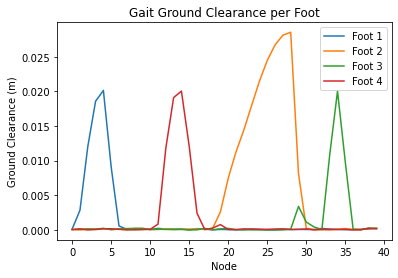

In [34]:
plt.plot(range(N),foot_1z)
plt.plot(range(N),foot_2z)
plt.plot(range(N),foot_3z)
plt.plot(range(N),foot_4z)
plt.legend(["Foot 1","Foot 2", "Foot 3", "Foot 4"])
plt.title('Gait Ground Clearance per Foot')
plt.xlabel('Node')
plt.ylabel('Ground Clearance (m)')
plt.savefig(r"C:"+path+gait_name+"_foot_lifts.png")

In [35]:
logger.info("Trajectory Optimisation Completed")
distance=m.q[N,3,'x'].value-m.q[1,1,'x'].value
logger.info(f"Distance travelled: {distance} m")
logger.info(f"Gait Duration: {duration} s")
logger.info(f"velocity (dist/time): {distance/duration}")
logger.info(f"Cost function value: {sum(((m.tau_h1[n].value**2+m.tau_k1[n].value**2+m.tau_h2[n].value**2+m.tau_k2[n].value**2+m.tau_h3[n].value**2+m.tau_k3[n].value**2+m.tau_h4[n].value**2+m.tau_k4[n].value**2)*m.h[n].value) for n in range(1,N+1))/m.q0[N,'x'].value}")
logger.info("-------------------------------------------------------")

[2023-10-27T09:25:51+0200.0443][INFO ][<ipython-input-35-bf6d4aa7f40c>] - Trajectory Optimisation Completed
[2023-10-27T09:25:51+0200.0445][INFO ][<ipython-input-35-bf6d4aa7f40c>] - Distance travelled: 0.10902964071263709 m
[2023-10-27T09:25:51+0200.0448][INFO ][<ipython-input-35-bf6d4aa7f40c>] - Gait Duration: 1.4669589451679528 s
[2023-10-27T09:25:51+0200.0450][INFO ][<ipython-input-35-bf6d4aa7f40c>] - velocity (dist/time): 0.07432358013274477
[2023-10-27T09:25:51+0200.0452][INFO ][<ipython-input-35-bf6d4aa7f40c>] - Cost function value: 0.15333421492270263
[2023-10-27T09:25:51+0200.0454][INFO ][<ipython-input-35-bf6d4aa7f40c>] - -------------------------------------------------------
